# Finite window bootstrap error

Estimate the error of our interior time estimator using bootstrapping for various trajectory counts.

## Variable definitions

In [1]:
import importlib
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.stats

import multi_locus_analysis as mla
import multi_locus_analysis.finite_window as fw
import multi_locus_analysis.plotting.finite_window as fplt
import bruno_util.plotting as bplt

figure_size = bplt.use_cell_style(mpl.rcParams)

In [2]:
from multi_locus_analysis.plotting import Variable
from scipy.stats import beta, expon, weibull_min
import seaborn as sns

variable_pairs = {}
windows = {}

# for Beta distributions, making the window size a little less than 1 guarantees there's not too many,
# and also not too fewobs per trajectory, so that the effect we want to show is visible
windows['beta'] = 0.8
variable_pairs['beta'] = [
    Variable(beta(5, 2), 
             name='Beta(5, 2)',
             pretty_name=r'Beta$(\alpha{}=5, \beta{}=2)$', 
             linestyle=':', 
             color=sns.color_palette('colorblind')[2],
             scaled_ylim=4.0),
    Variable(beta(2, 2),
             name='Beta(2, 2)',
             pretty_name=r'Beta$(\alpha{}=2, \beta{}=2)$', 
             linestyle='--', 
             color=sns.color_palette('colorblind')[3],
             scaled_ylim=2.0)
]


windows['exp'] = 2 + 4 + 2
variable_pairs['exp'] = [
    Variable(expon(scale=4), 
             name=f'Exp(4)', 
             linestyle=':', 
             color=sns.color_palette('colorblind')[4],
             scaled_ylim=0.3),
    Variable(expon(loc=2, scale=2), 
             name=f'Exp(2) + 2', 
             linestyle='--', 
             color=sns.color_palette('colorblind')[5],
             scaled_ylim=0.5)
]


windows['weibull'] = 10
variable_pairs['weibull'] = [
    Variable(
        weibull_min(c=0.5),
        name=r'W(1/2)',
        pretty_name=r'$W(1/2)$',
        linestyle=':', 
        color=sns.color_palette('colorblind')[2],
        scaled_ylim=2
    ),
    Variable(
        weibull_min(c=0.75),
        name=r'W(3/4)',
        pretty_name=r'$W(3/4)$',
        linestyle='--', 
        color=sns.color_palette('colorblind')[3],
        scaled_ylim=3
    )
    
]

## $L^2$ Consistency Check

In [43]:
importlib.reload(fw.simulation)
importlib.reload(fw)


<module 'multi_locus_analysis.finite_window' from '/home/bbeltr1/developer/multi_locus_analysis/multi_locus_analysis/finite_window/__init__.py'>

In [3]:
which_pair = 'exp'
var_pair = variable_pairs[which_pair]
T = windows[which_pair]

about a minute overhead (N_boot=3), then scales not bad...2min for N_boot=10...

don't use more than 10 for exp, 5? for weibull. up to 100 for beta is fine.

In [30]:
Nt

100000.0

In [17]:
%%time
import datetime
import pickle

N_boot = 10
N_traj_p = 3, 5, 11  # for easy saving later
N_traj = np.logspace(*N_traj_p)
err_aves = []
err_stds = []
l2_aves = []
l2_stds = []
for Nt in N_traj:
    err_t, err_ave, err_std, l2_ave, l2_std, linf_ave, linf_std \
        = fw.bootstrap_int_error(var_pair, T, N_boot, int(Nt))
    err_aves.append(err_ave)
    err_stds.append(err_std)
    l2_aves.append(l2_ave)
    l2_stds.append(l2_std)
    linf_aves.append(linf_ave)
    linf_stds.append(linf_std)
def dict_list_to_list_dict(dl):
    names = dl[0].keys()
    return {name: np.array([dic[name] for dic in dl])
            for name in names}
l2_aves = dict_list_to_list_dict(l2_aves)
l2_stds = dict_list_to_list_dict(l2_stds)
linf_aves = dict_list_to_list_dict(linf_aves)
linf_stds = dict_list_to_list_dict(linf_stds)

utc_time = datetime.datetime.utcnow()
pkl_folder = '/home/bbeltr1/Documents/work/ajspakow/finite-window/simulations/'
pkl_name = pkl_folder \
    + f'consistency-run-{N_boot}boots-{N_traj_p}traj-{which_pair}-' \
    + utc_time.strftime('%Y%m%d-%H%M%S') + '.pkl'
with open(pkl_name, 'wb') as f:
    pickle.dump((err_t, err_aves, err_stds, l2_aves, l2_stds, linf_aves, linf_stds), f)

CPU times: user 205 ms, sys: 615 ms, total: 820 ms
Wall time: 2min 1s


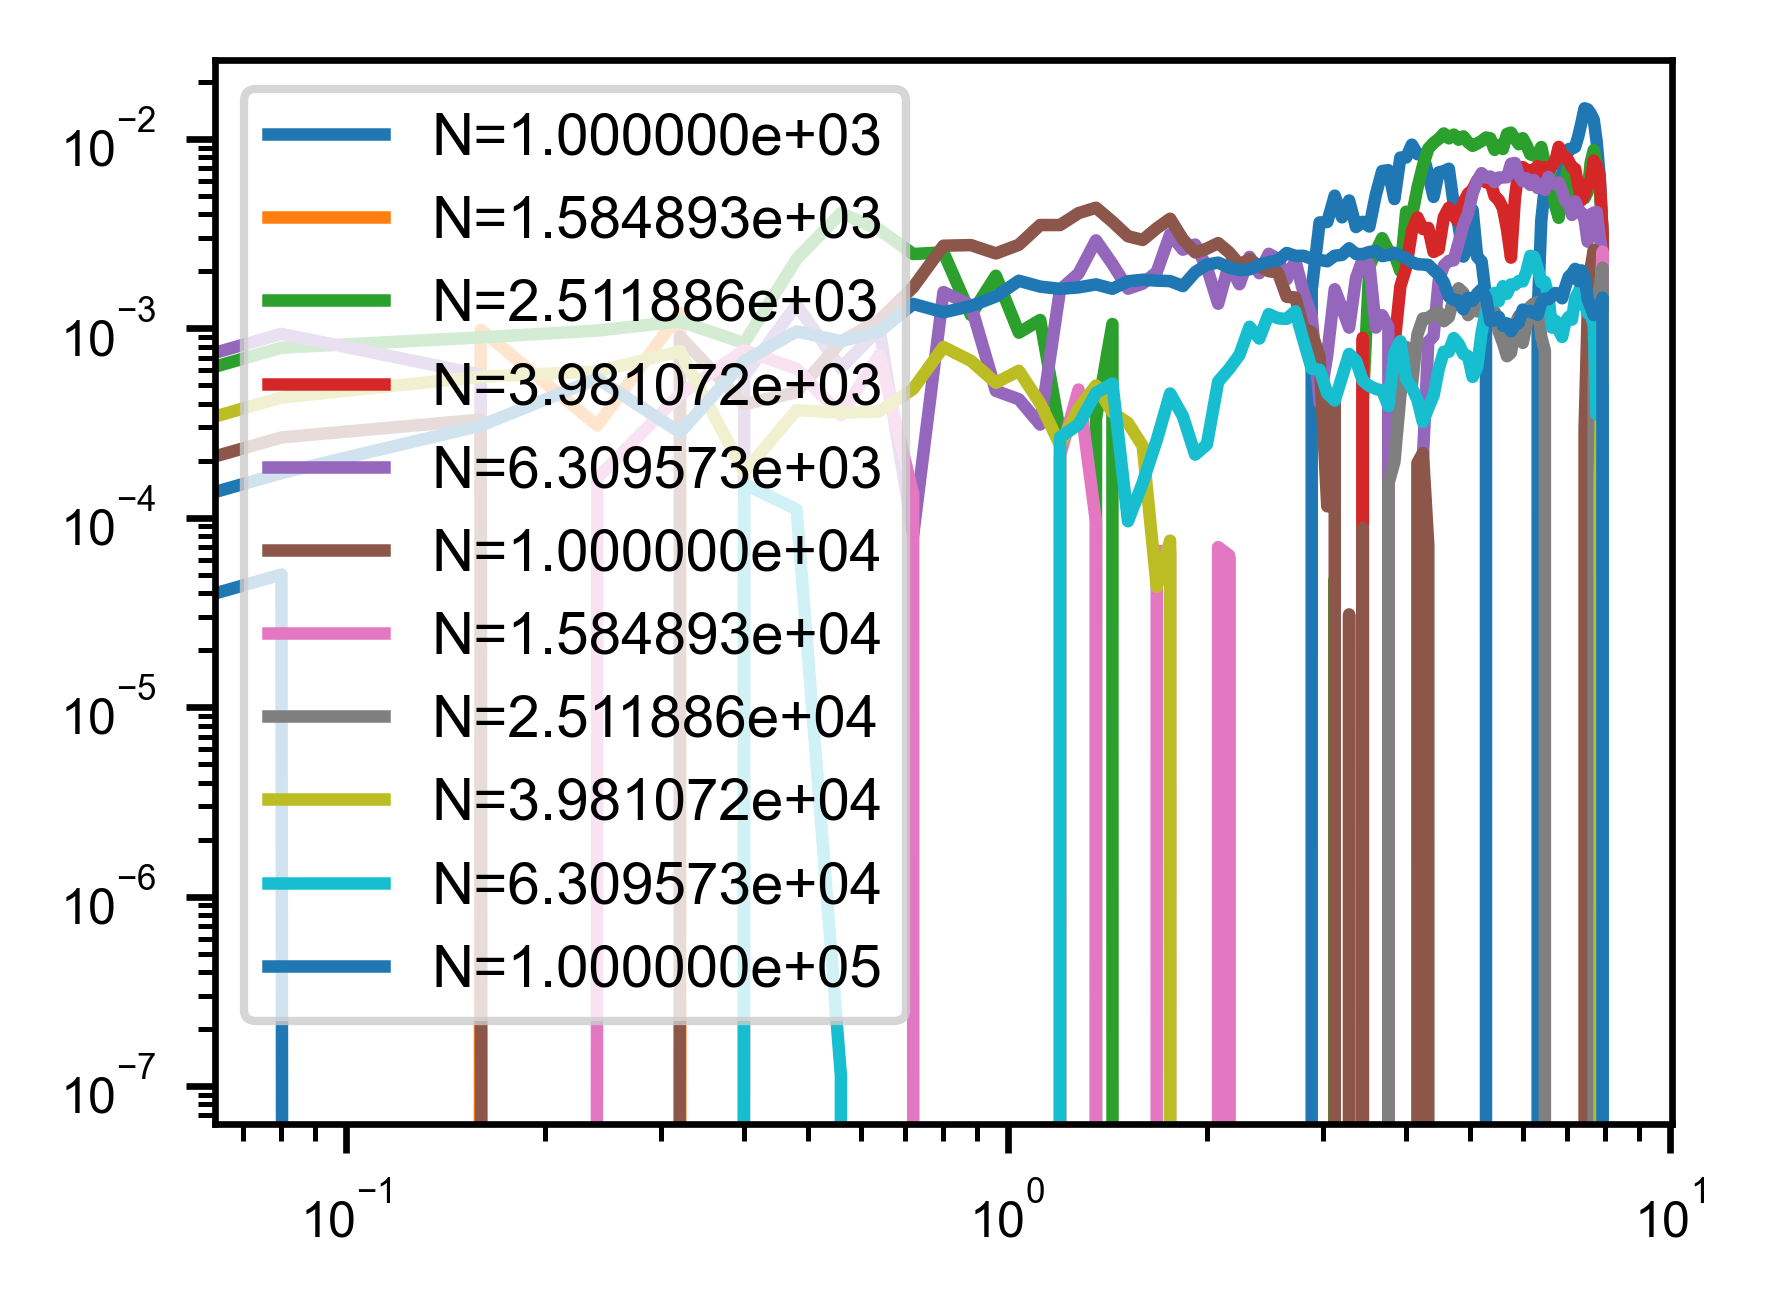

In [18]:
var = var_pair[0]
for i, Nt in enumerate(N_traj):
    plt.plot(err_t, -err_aves[i][var.name], label=f"N={Nt:e}")
plt.xscale('log')
plt.yscale('log')
plt.legend()

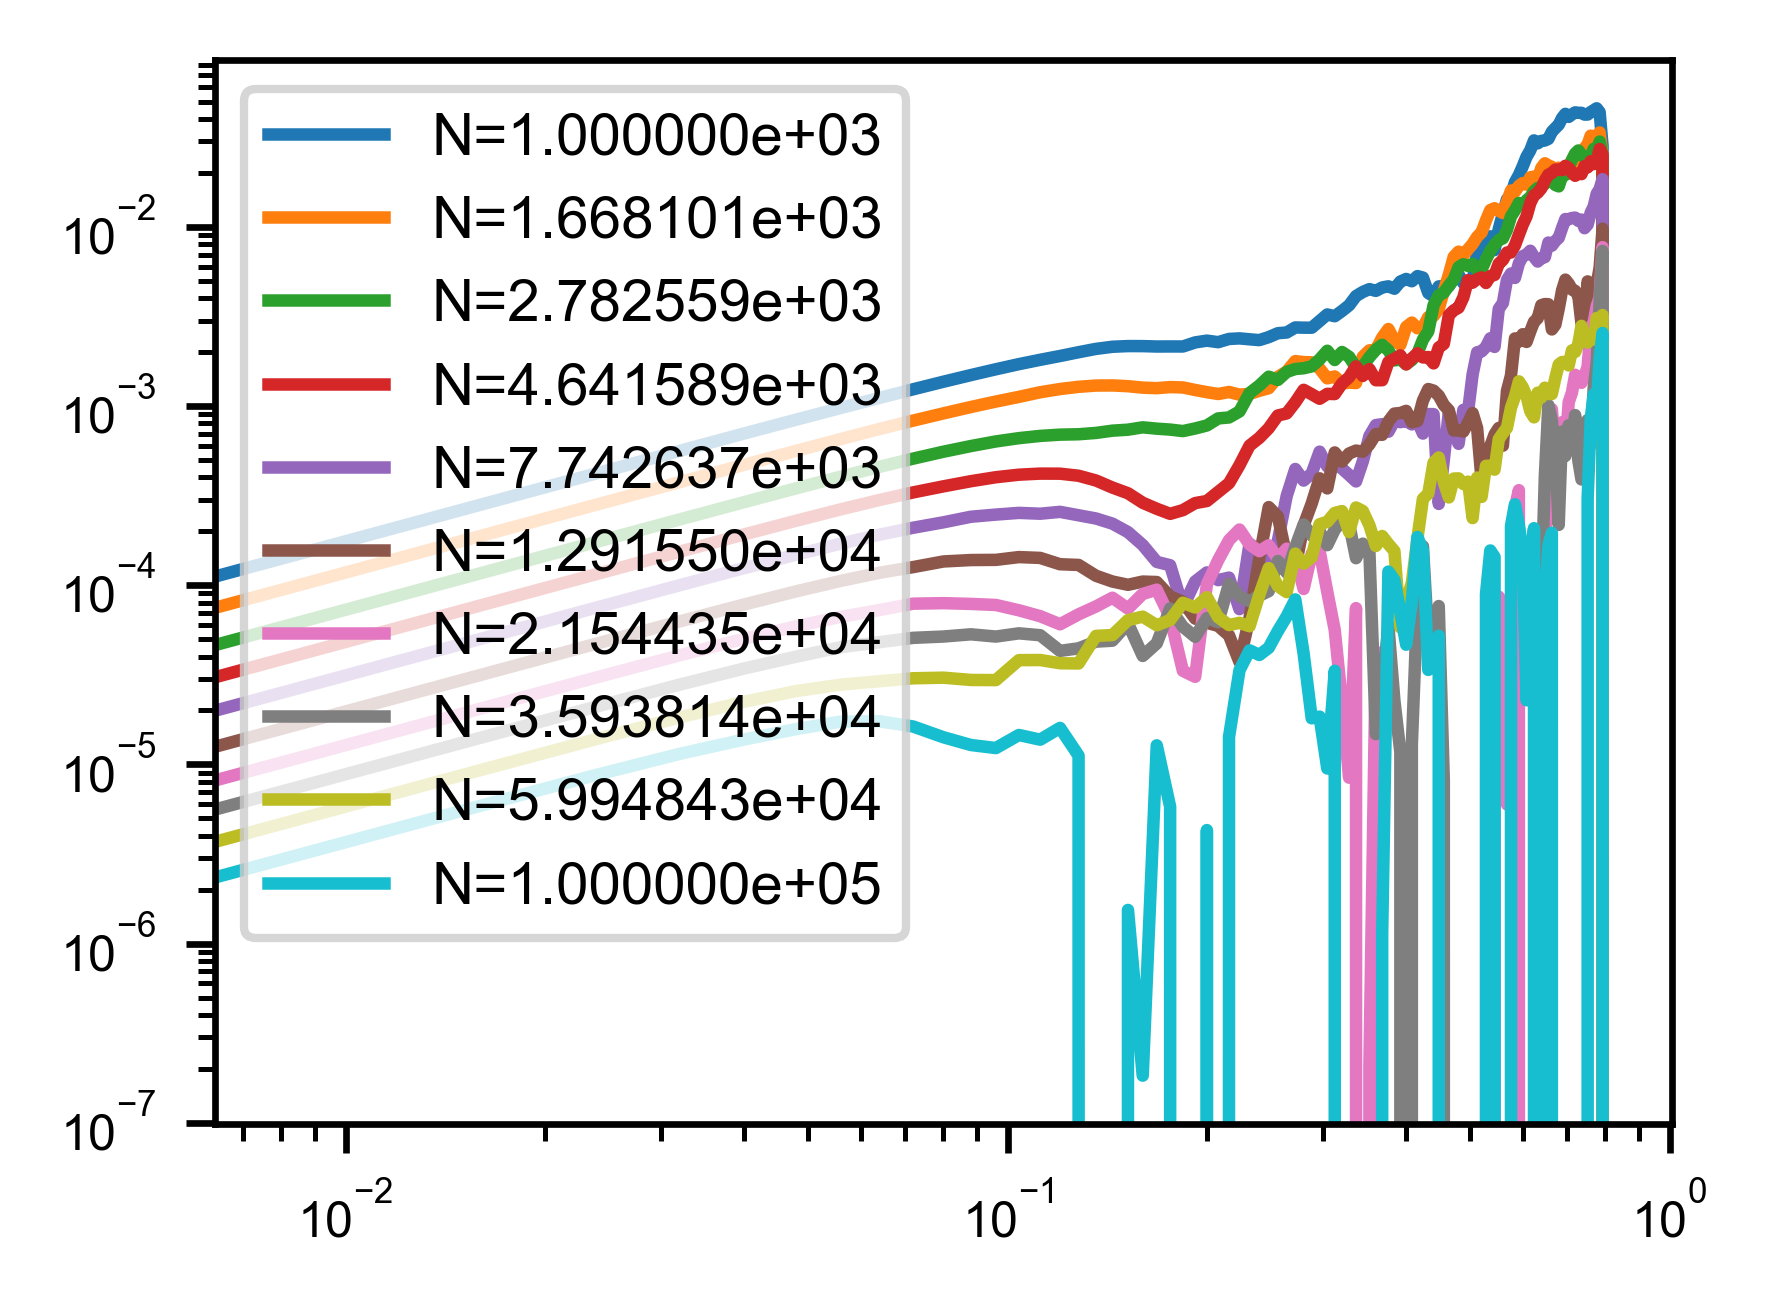

In [59]:
var = var_pair[0]
for i, Nt in enumerate(N_traj):
    plt.plot(err_t, -err_aves[i][var.name], label=f"N={Nt:e}")
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [76]:
importlib.reload(bplt)

<module 'bruno_util.plotting' from '/home/bbeltr1/developer/bruno_util/bruno_util/plotting.py'>

In [20]:
l2_ave

{'Exp(4)': 0.07792031700135083, 'Exp(2) + 2': 0.06676405270775243}

Text(0, 0.5, 'E[$L^2$ error]')

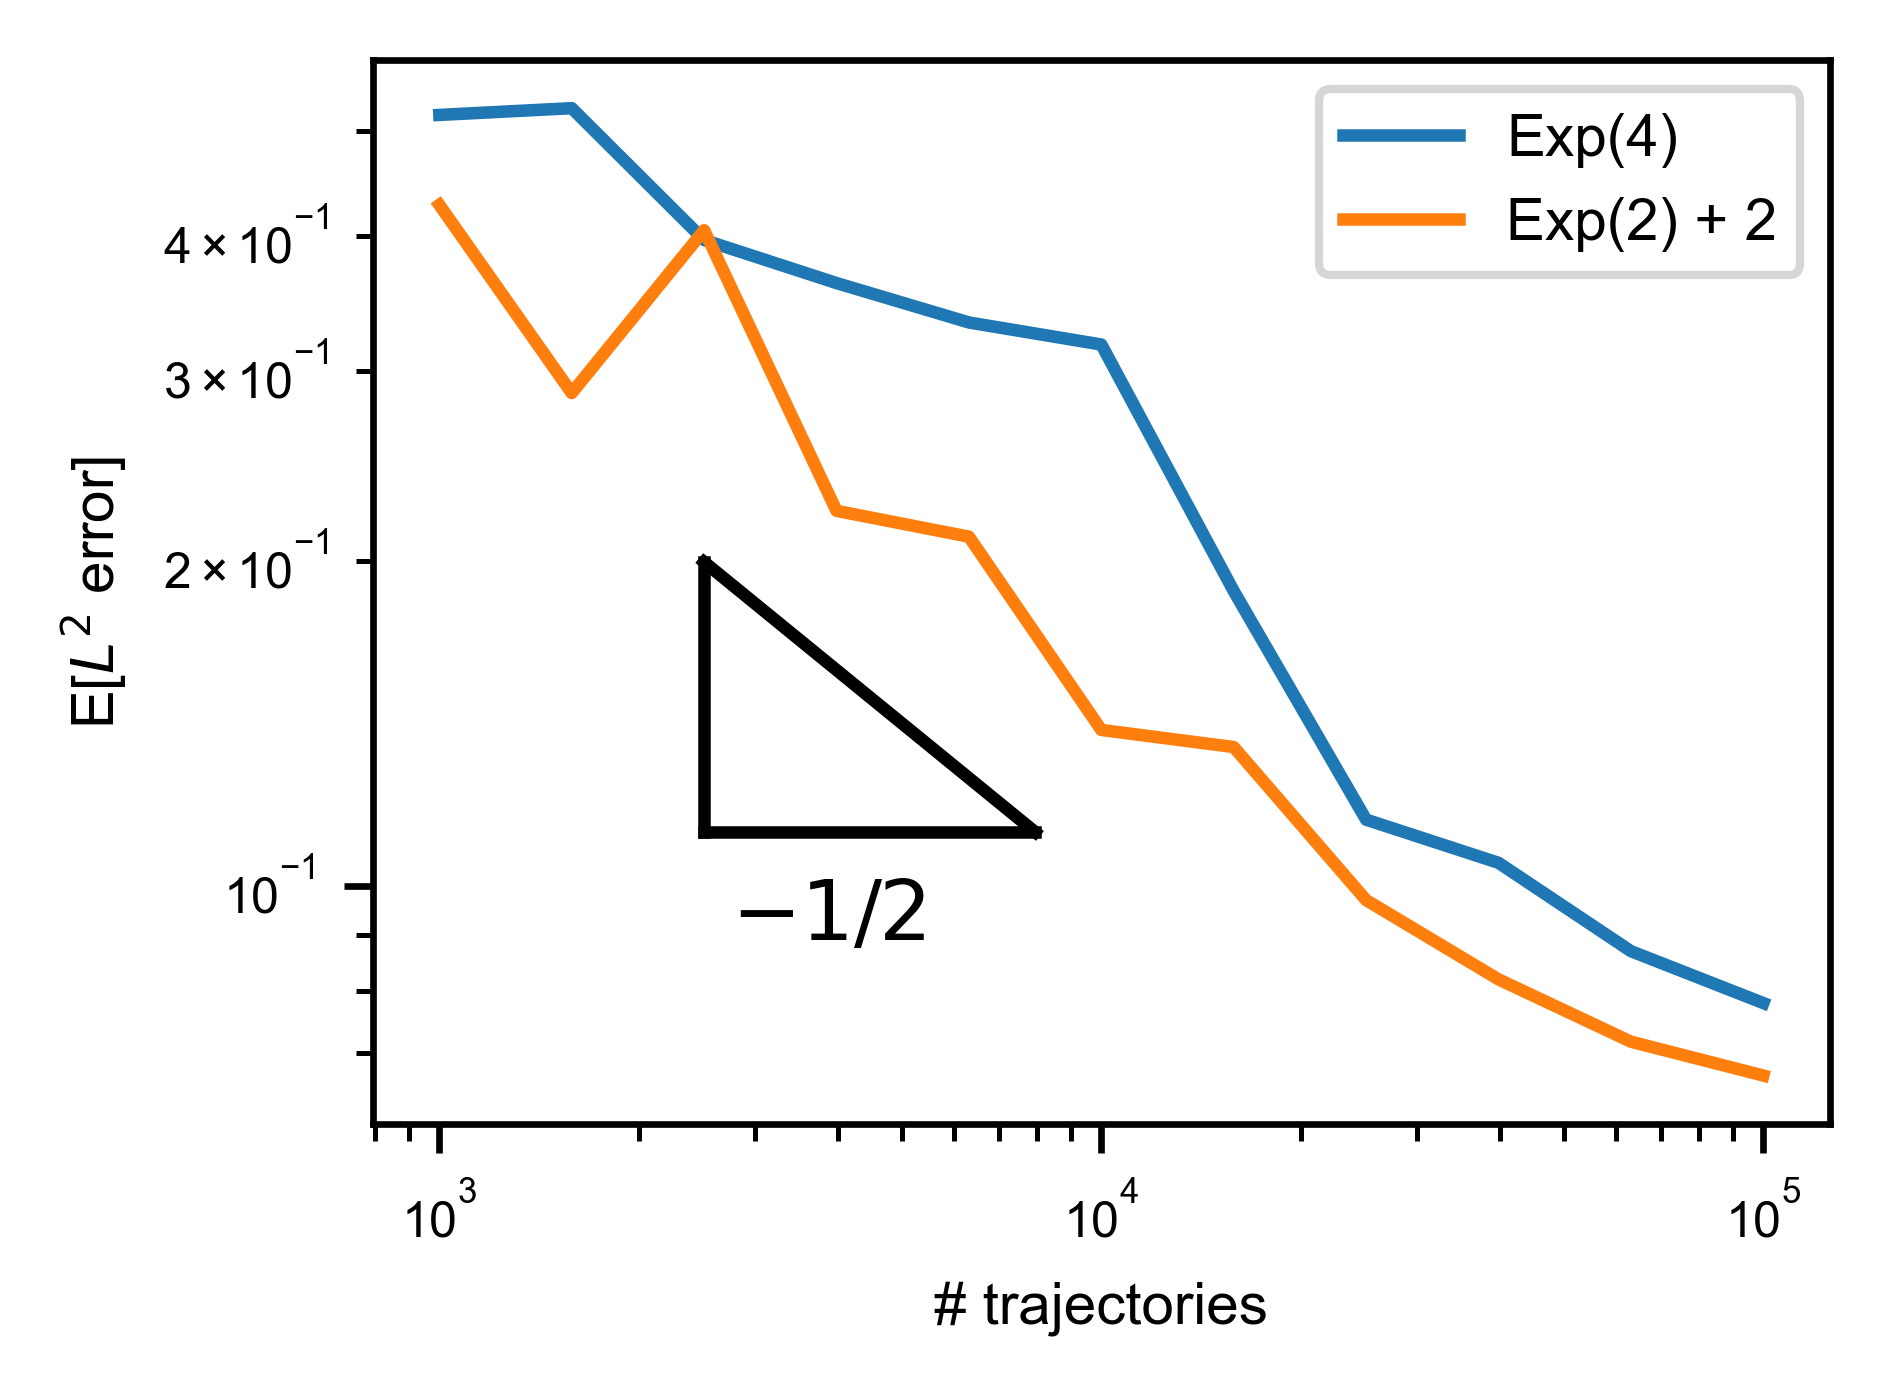

In [29]:
for var in var_pair:
    plt.plot(N_traj, l2_aves[var.name], label=var.pretty_name)
bplt.draw_power_law_triangle(
    alpha=-1/2, x0=[3.4, -0.7], width=1/2, orientation='down',
    label='$-1/2$', label_padding=0.33, label_dx=[-600, 0]
)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('# trajectories')
plt.ylabel('E[$L^2$ error]')

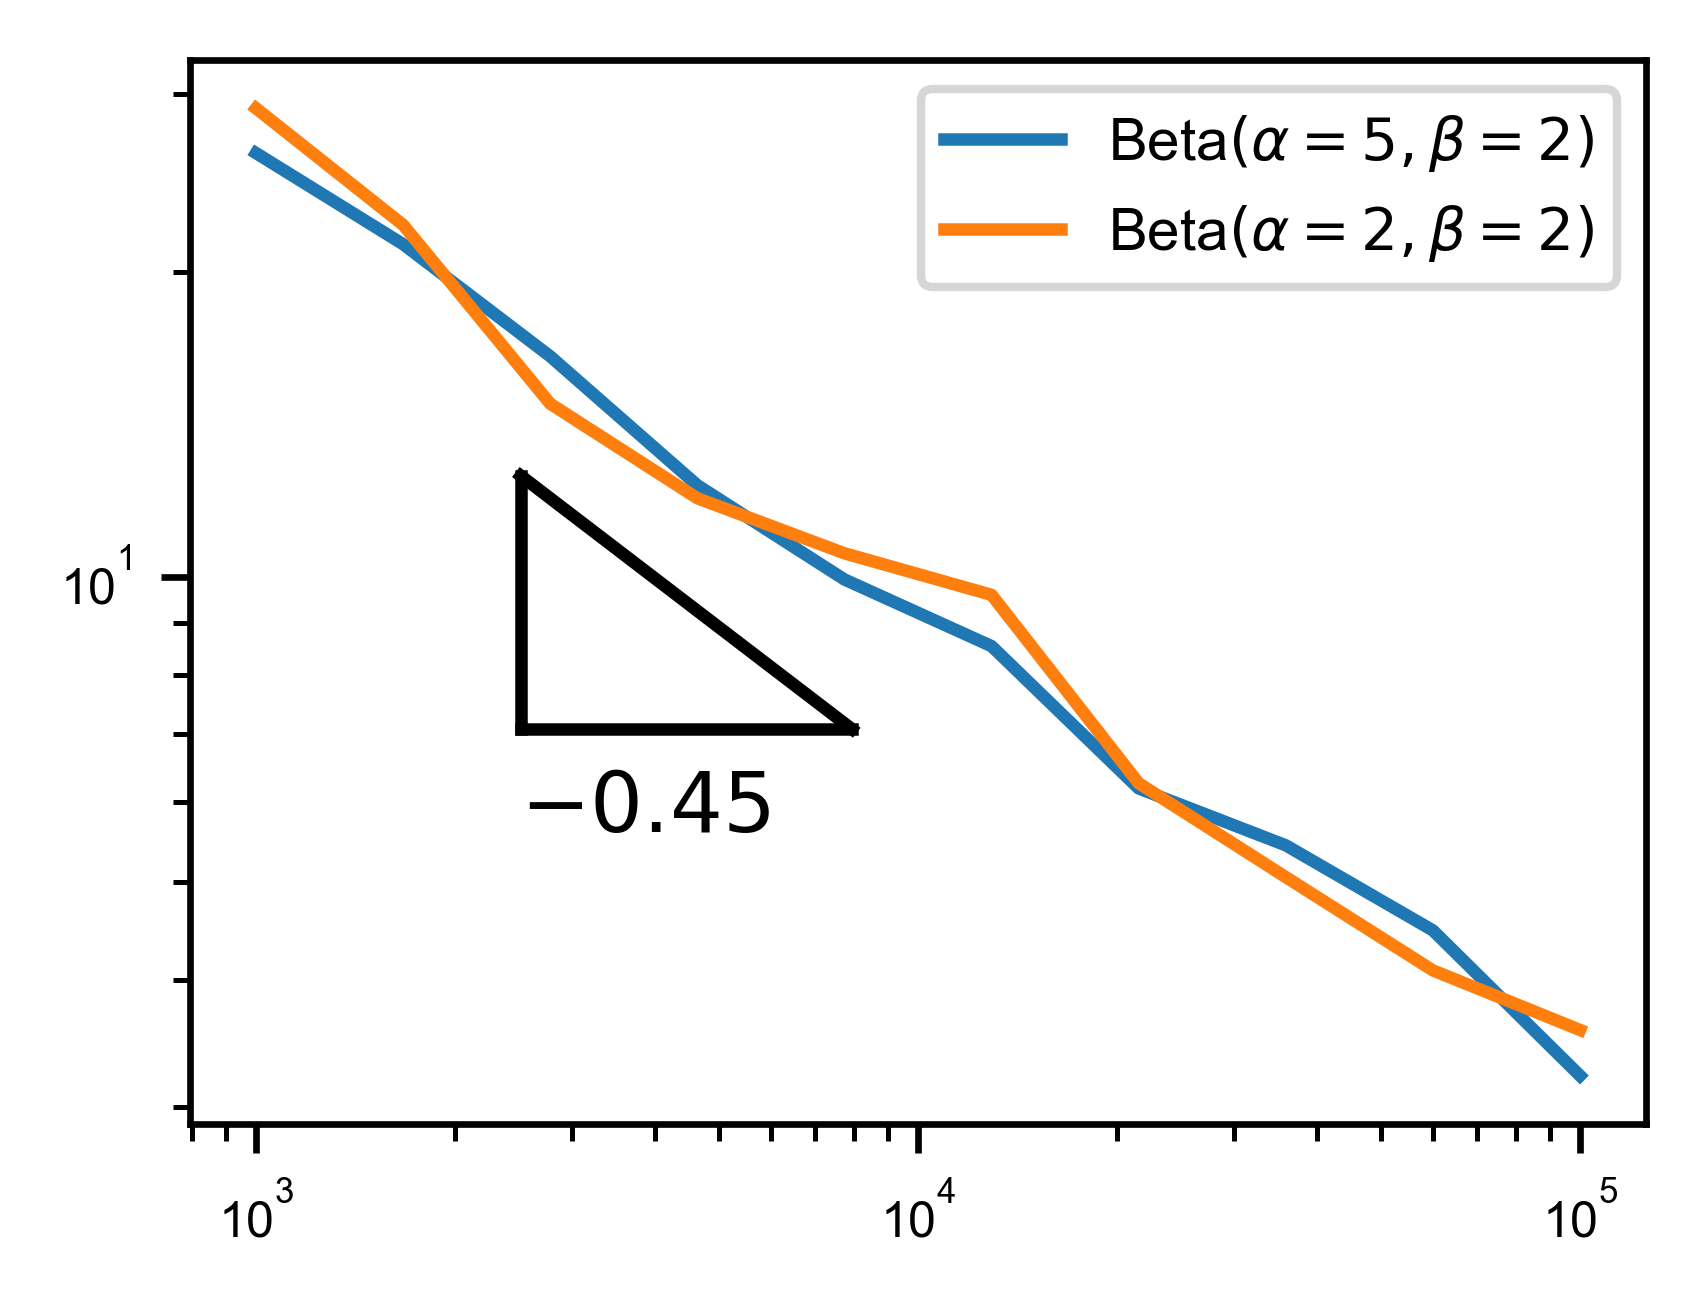

In [89]:
for var in var_pair:
    plt.plot(N_traj, l2_ave[var.name], label=var.pretty_name)
bplt.draw_power_law_triangle(
    alpha=-1/2, x0=[3.4, 1.1], width=1/2, orientation='down',
    label='$-0.45$', label_padding=0.33, label_dx=[-600, 0]
)
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [51]:
pickleable_var_pair = tuple((var.name, var.rv) for var in var_pair)
N_var_T = (N_traj_per_boot, pickleable_var_pair, err_t)
N_traj_per_boot, var_pair, err_t = N_var_T
T = np.max(err_t)
var_pair = {name: var for name, var in var_pair}
sim = fw.ab_window(
    [var.rvs for _, var in var_pair.items()],
    offset=-100*np.sum([var.mean() for _, var in var_pair.items()]),
    window_size=T,
    num_replicates=N_traj_per_boot,
    states=[name for name in var_pair]
)
obs = fw.sim_to_obs(sim)
res = {}
for name, var in var_pair.items():
    exterior = fplt._ext_from_obs(obs, name)
    interior, _ = fplt._int_win_from_obs(obs, name)
    x, cdf = fw.ecdf_windowed(interior, T)
    res[name] = var.cdf(err_t)/var.cdf(T) - np.interp(err_t, x, cdf)

In [84]:
for var in var_pair:
    print(scipy.stats.linregress(np.log10(N_traj), np.log10(l2_errs[var.name])))

LinregressResult(slope=-0.4450442987615271, intercept=2.7472321509868247, rvalue=-0.9977975059748602, pvalue=1.0268067435317818e-10, stderr=0.010460415536989552, intercept_stderr=0.042371019922547236)
LinregressResult(slope=-0.451754807088091, intercept=2.7800294381348536, rvalue=-0.9925404094399977, pvalue=1.3425952430159872e-08, stderr=0.019618719415996702, intercept_stderr=0.07946769880131299)


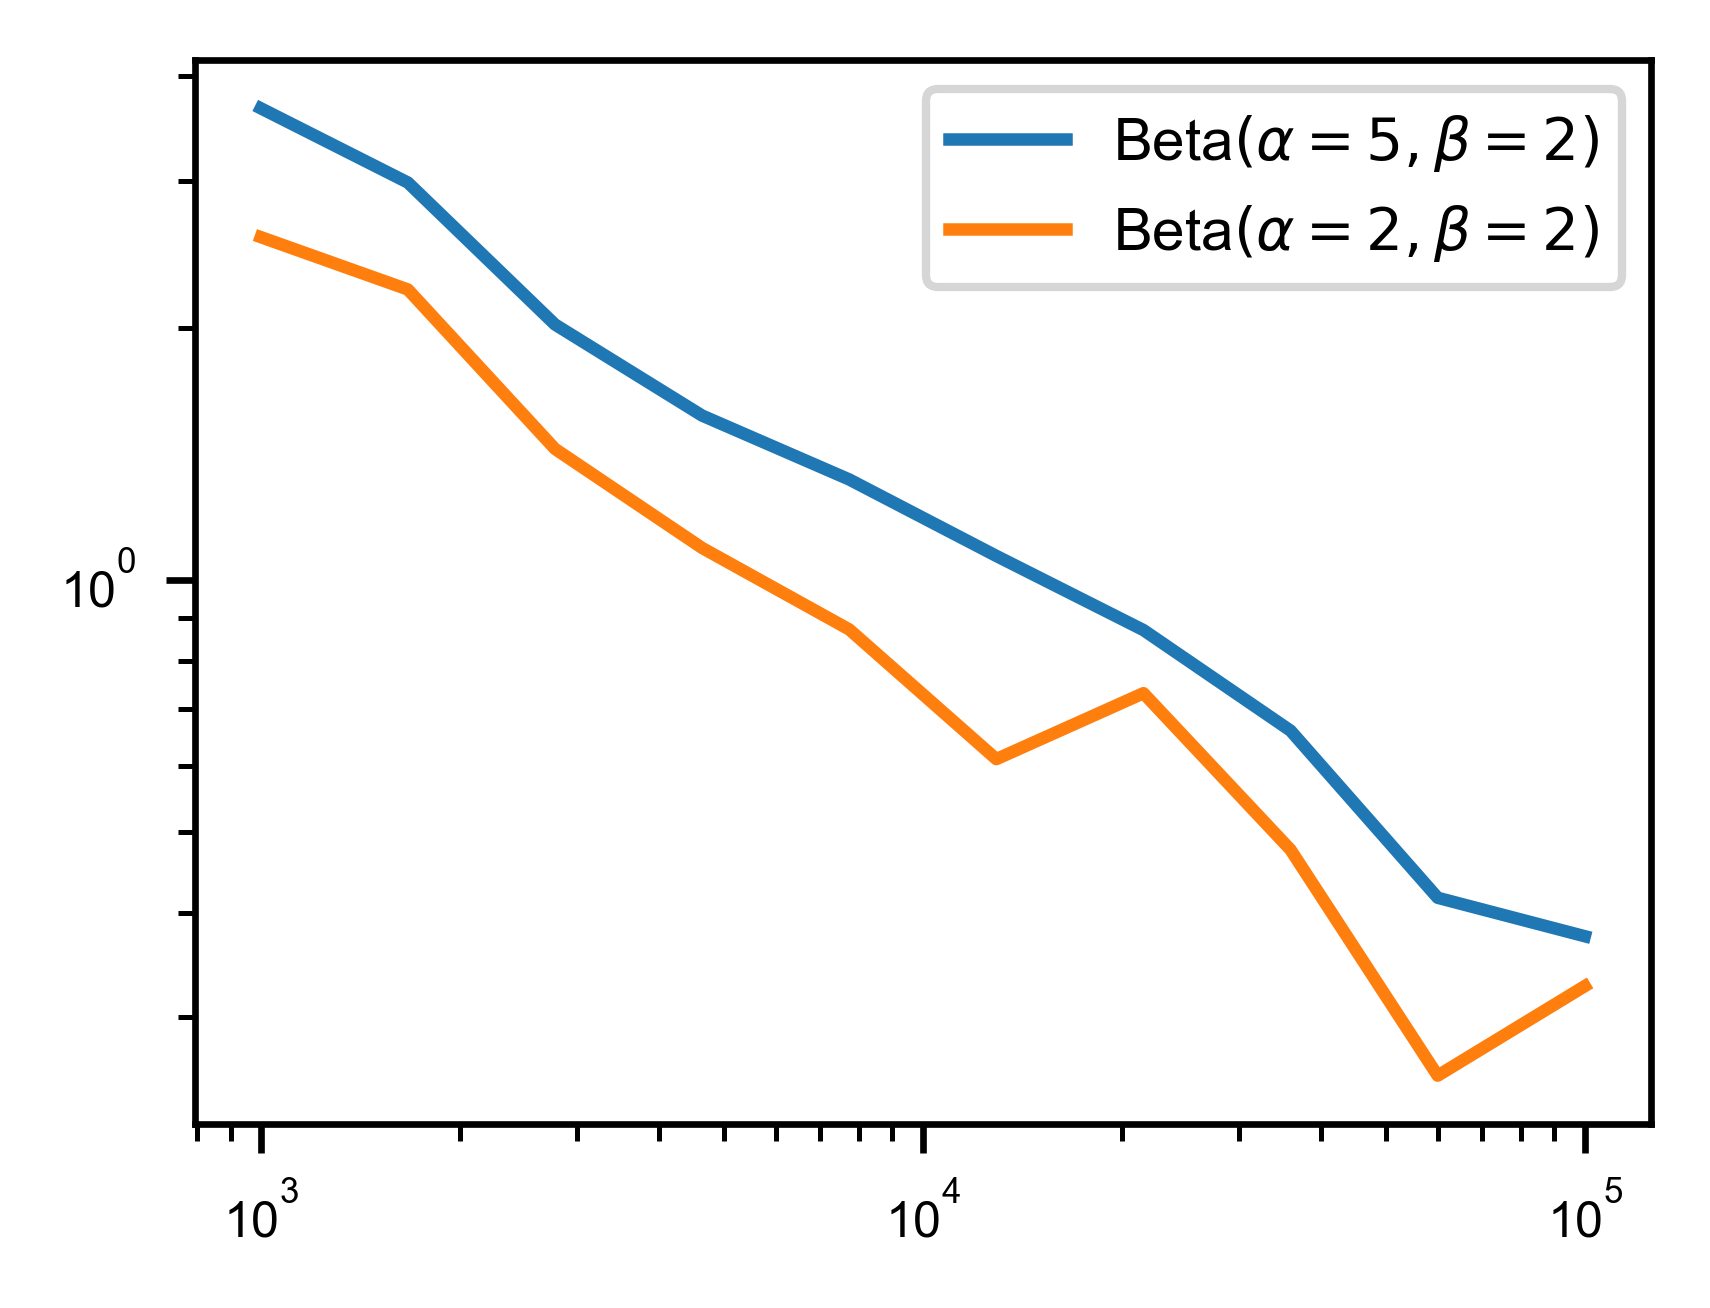

In [40]:
for var in var_pair:
    plt.plot(N_traj, l2_errs[var.name], label=var.pretty_name)
plt.xscale('log')
plt.yscale('log')
plt.legend()

## Fitting exp

In [ ]:
%%time
N_boots = np.array([1e5, 1e4, 1e3, 1e2]).astype(int)
N_trajs = np.array([1e2, 1e3, 1e4, 1e5]).astype(int)
for N_boot, N_traj in zip(N_boots, N_trajs):
    df = fw.simulation.bootstrap_exp_fit_error(N_boot, N_traj)
    folder = '/home/bbeltr1/Documents/work/ajspakow/finite-window/simulations/'
    utc_time = datetime.datetime.utcnow().strftime('%Y%m%d-%H%M%S')
    file = f'exp_fit_{N_boot}Nboot_{N_traj}Ntraj-{utc_time}.csv'
    df.to_csv(folder + file)

## Fitting power law

### Weibull (aka "fake" power law) needs care

In generall, Weibull actually falls off

In [ ]:
cmap = mpl.cm.get_cmap('viridis')
cnorm = mpl.colors.Normalize(0, 1)
    

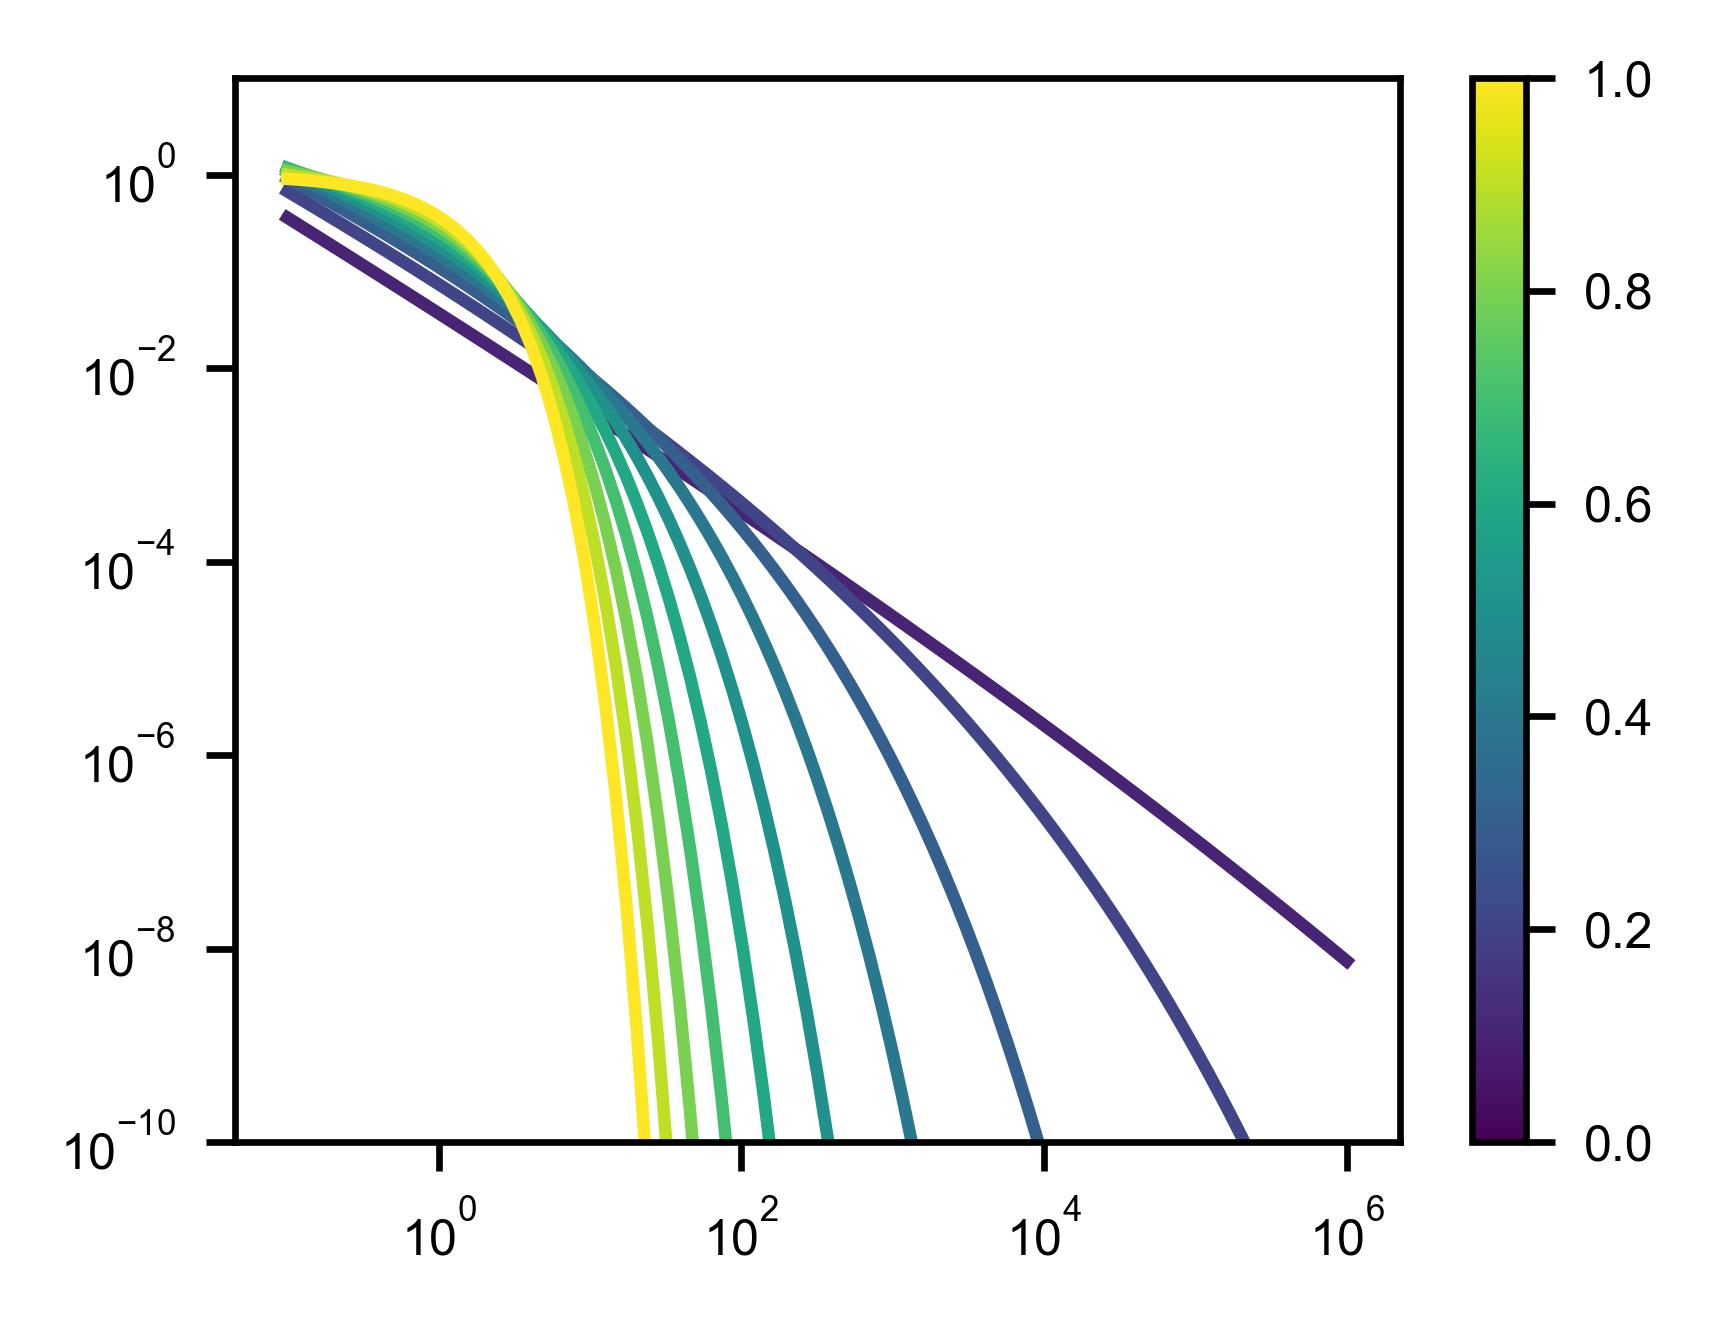

In [27]:
t = np.logspace(-1, 6, 101)
ks = np.linspace(0, 1, 11)
for k in ks[1:]:
    var = weibull_min(k)
    plt.plot(t, var.pdf(t), c=cmap(cnorm(k)))
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-10, 1e1])
sm = mpl.cm.ScalarMappable(cnorm, cmap)
sm.set_array([])
plt.colorbar(sm)

But at early times it appears to have a particular slope ($\alpha \approx k - 1$)

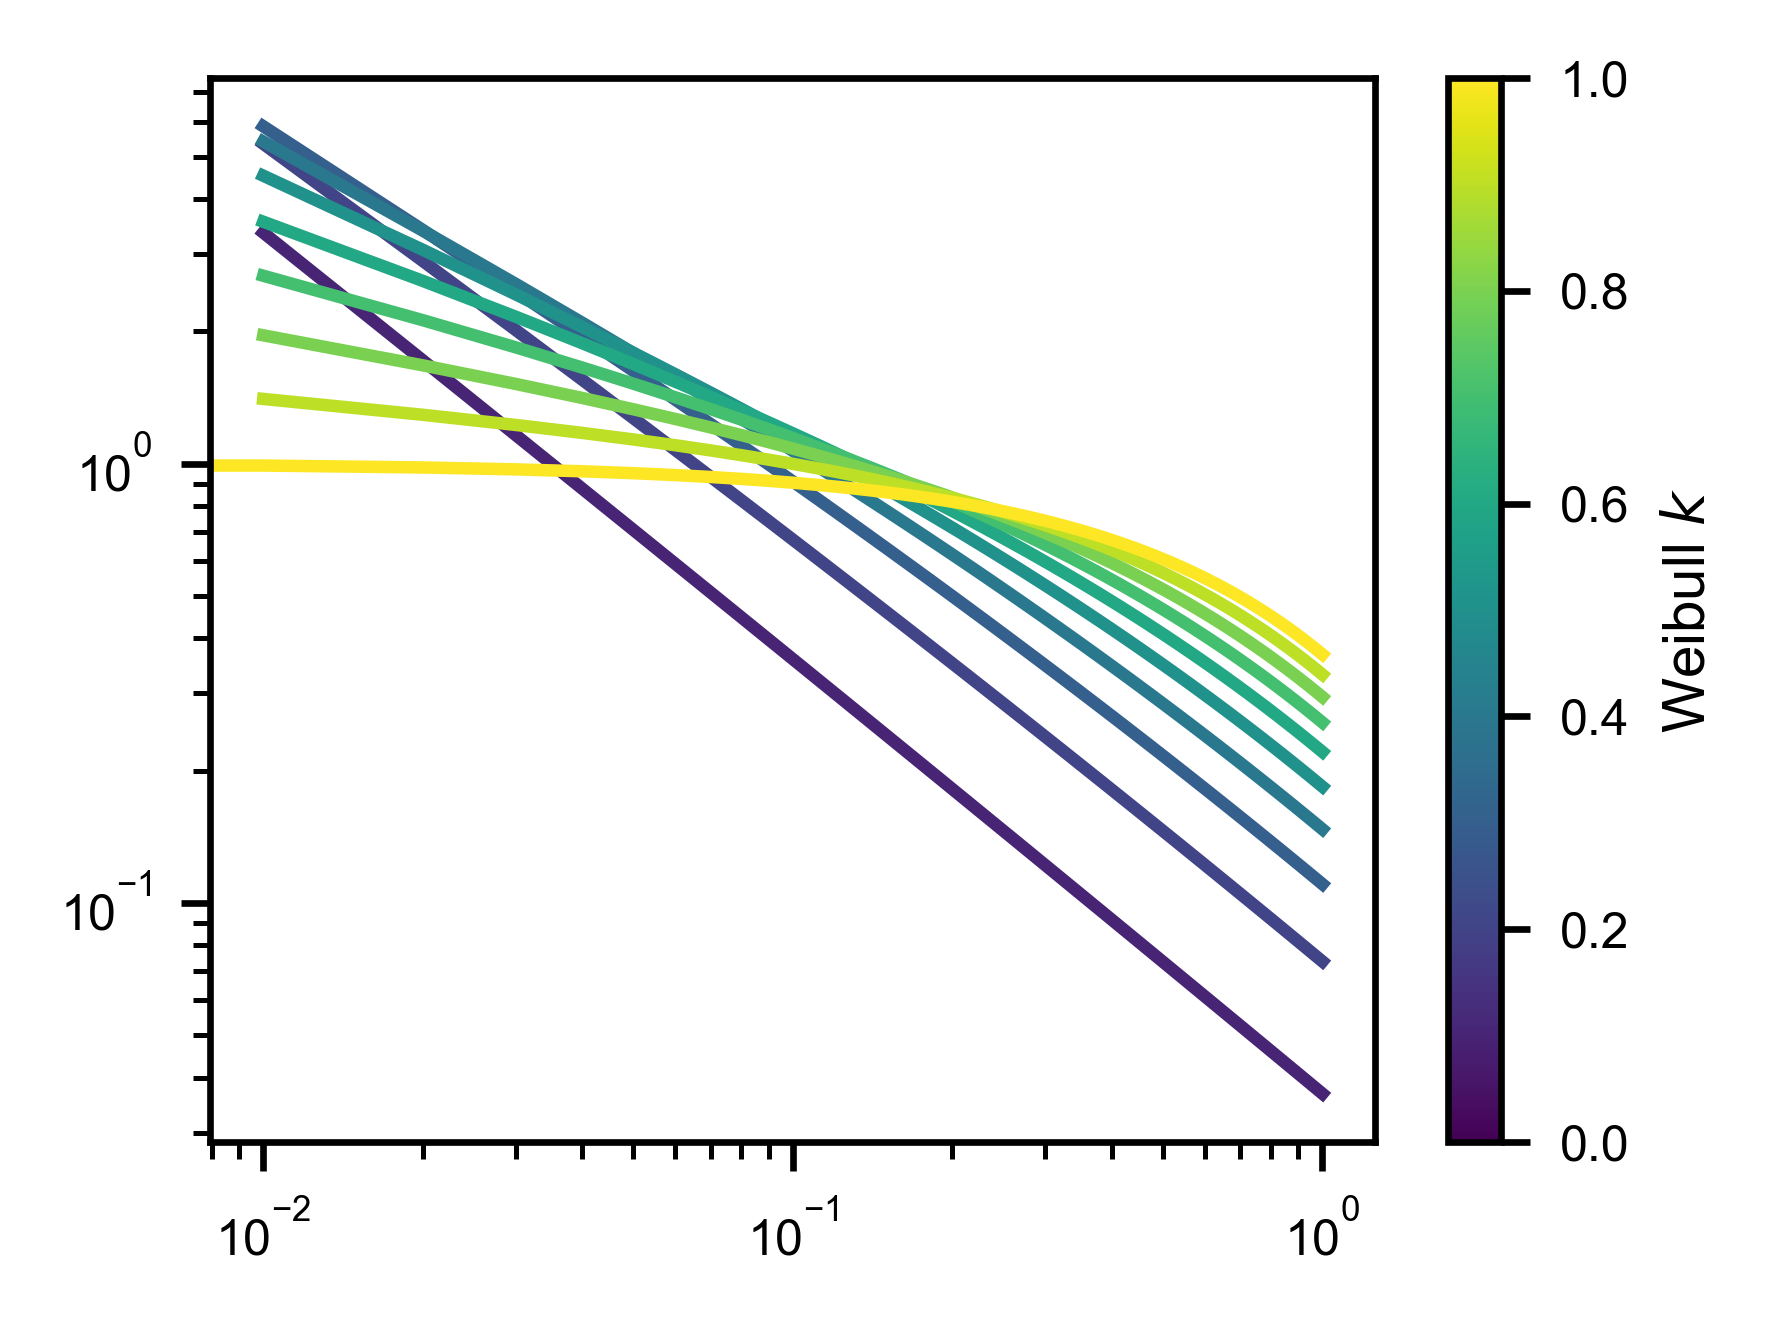

In [30]:
t = np.linspace(0, 1, 101)
ks = np.linspace(0, 1, 11)
for k in ks:
    plt.plot(t, weibull_min(k).pdf(t), c=cmap(cnorm(k)))
plt.xscale('log')
plt.yscale('log')
sm = mpl.cm.ScalarMappable(cnorm, cmap)
sm.set_array([])
cb = plt.colorbar(sm)
cb.set_label('Weibull $k$')


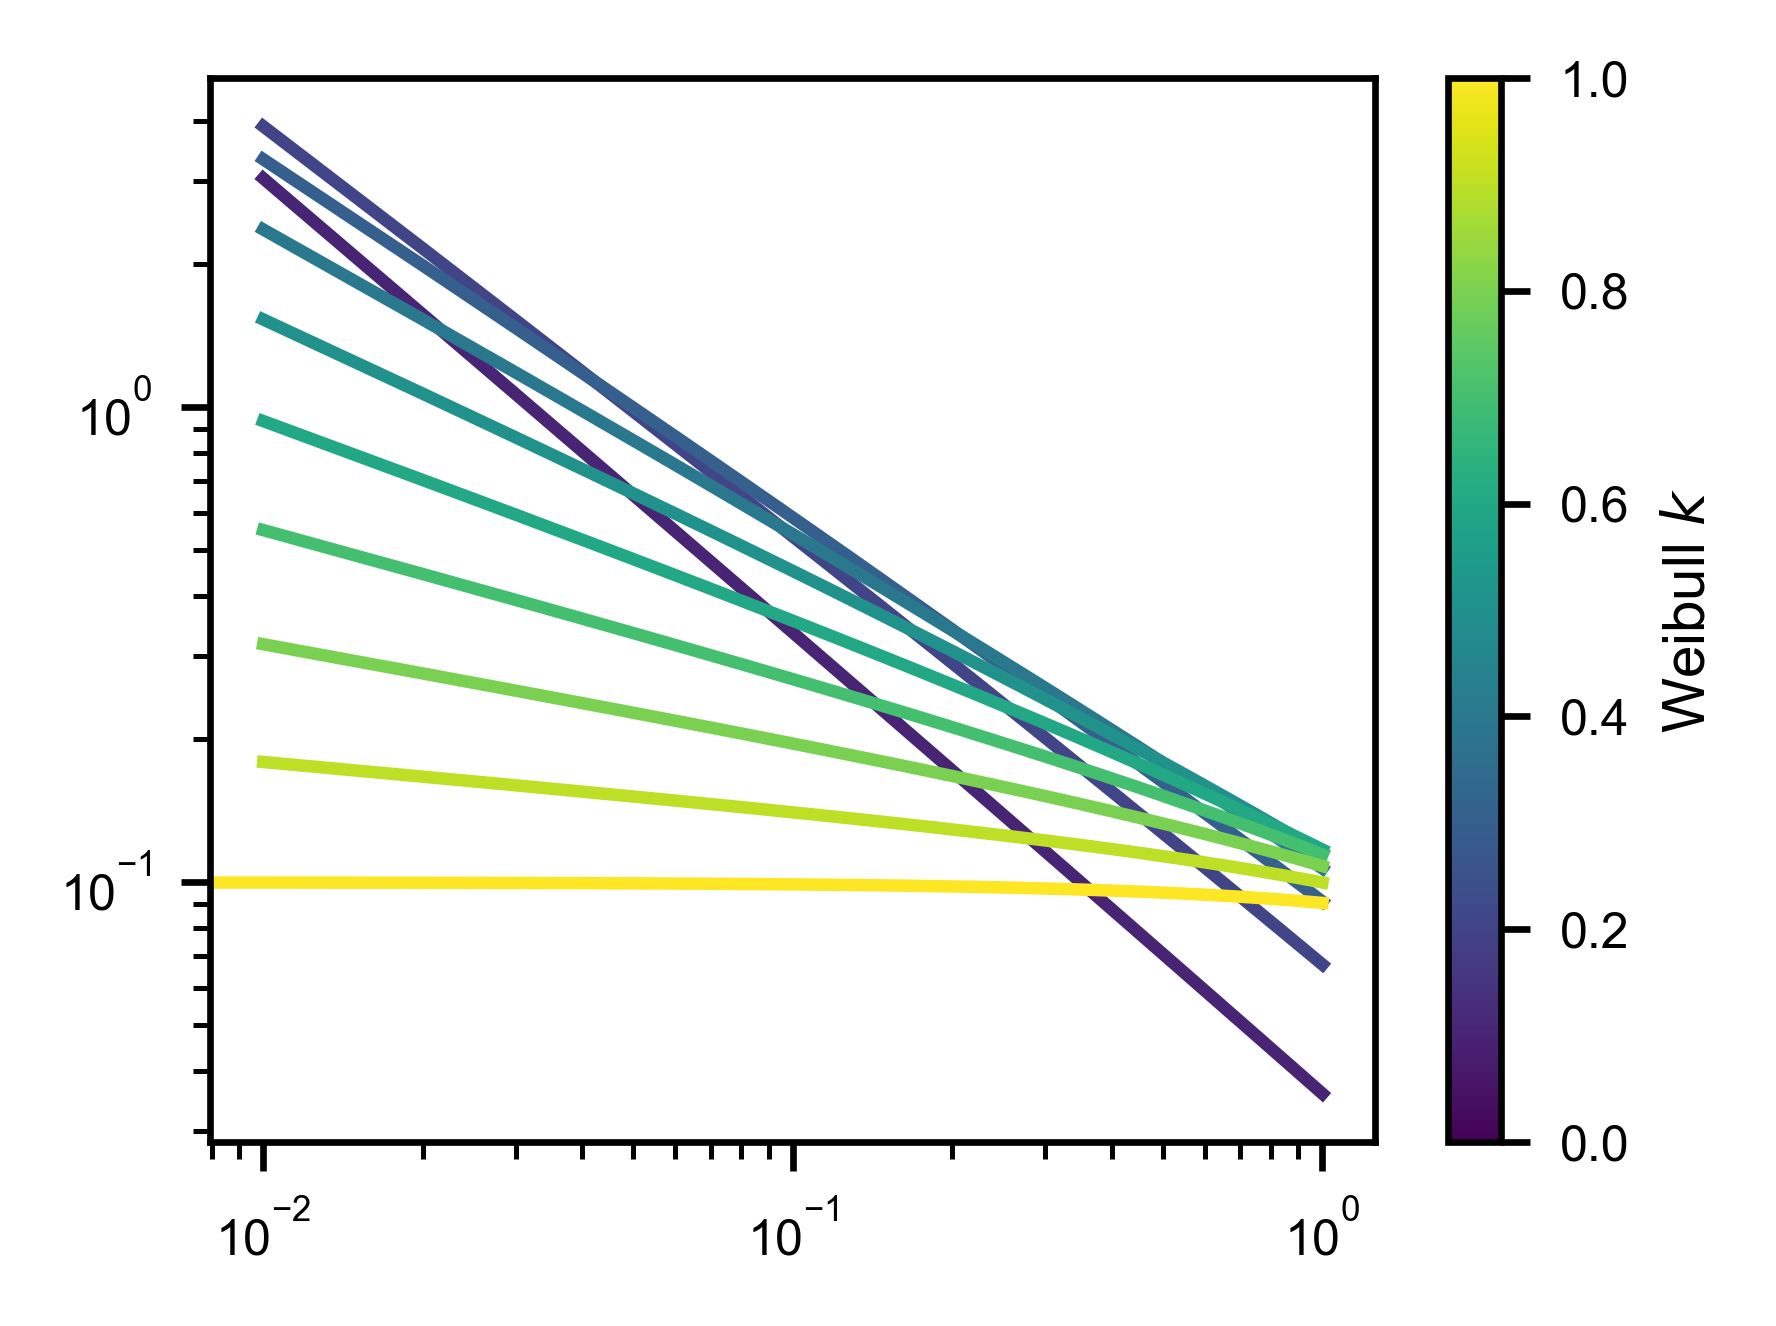

In [31]:
t = np.linspace(0, 1, 101)
ks = np.linspace(0, 1, 11)
for k in ks:
    plt.plot(t, weibull_min(k, scale=10).pdf(t), c=cmap(cnorm(k)))
plt.xscale('log')
plt.yscale('log')
sm = mpl.cm.ScalarMappable(cnorm, cmap)
sm.set_array([])
cb = plt.colorbar(sm)
cb.set_label('Weibull $k$')

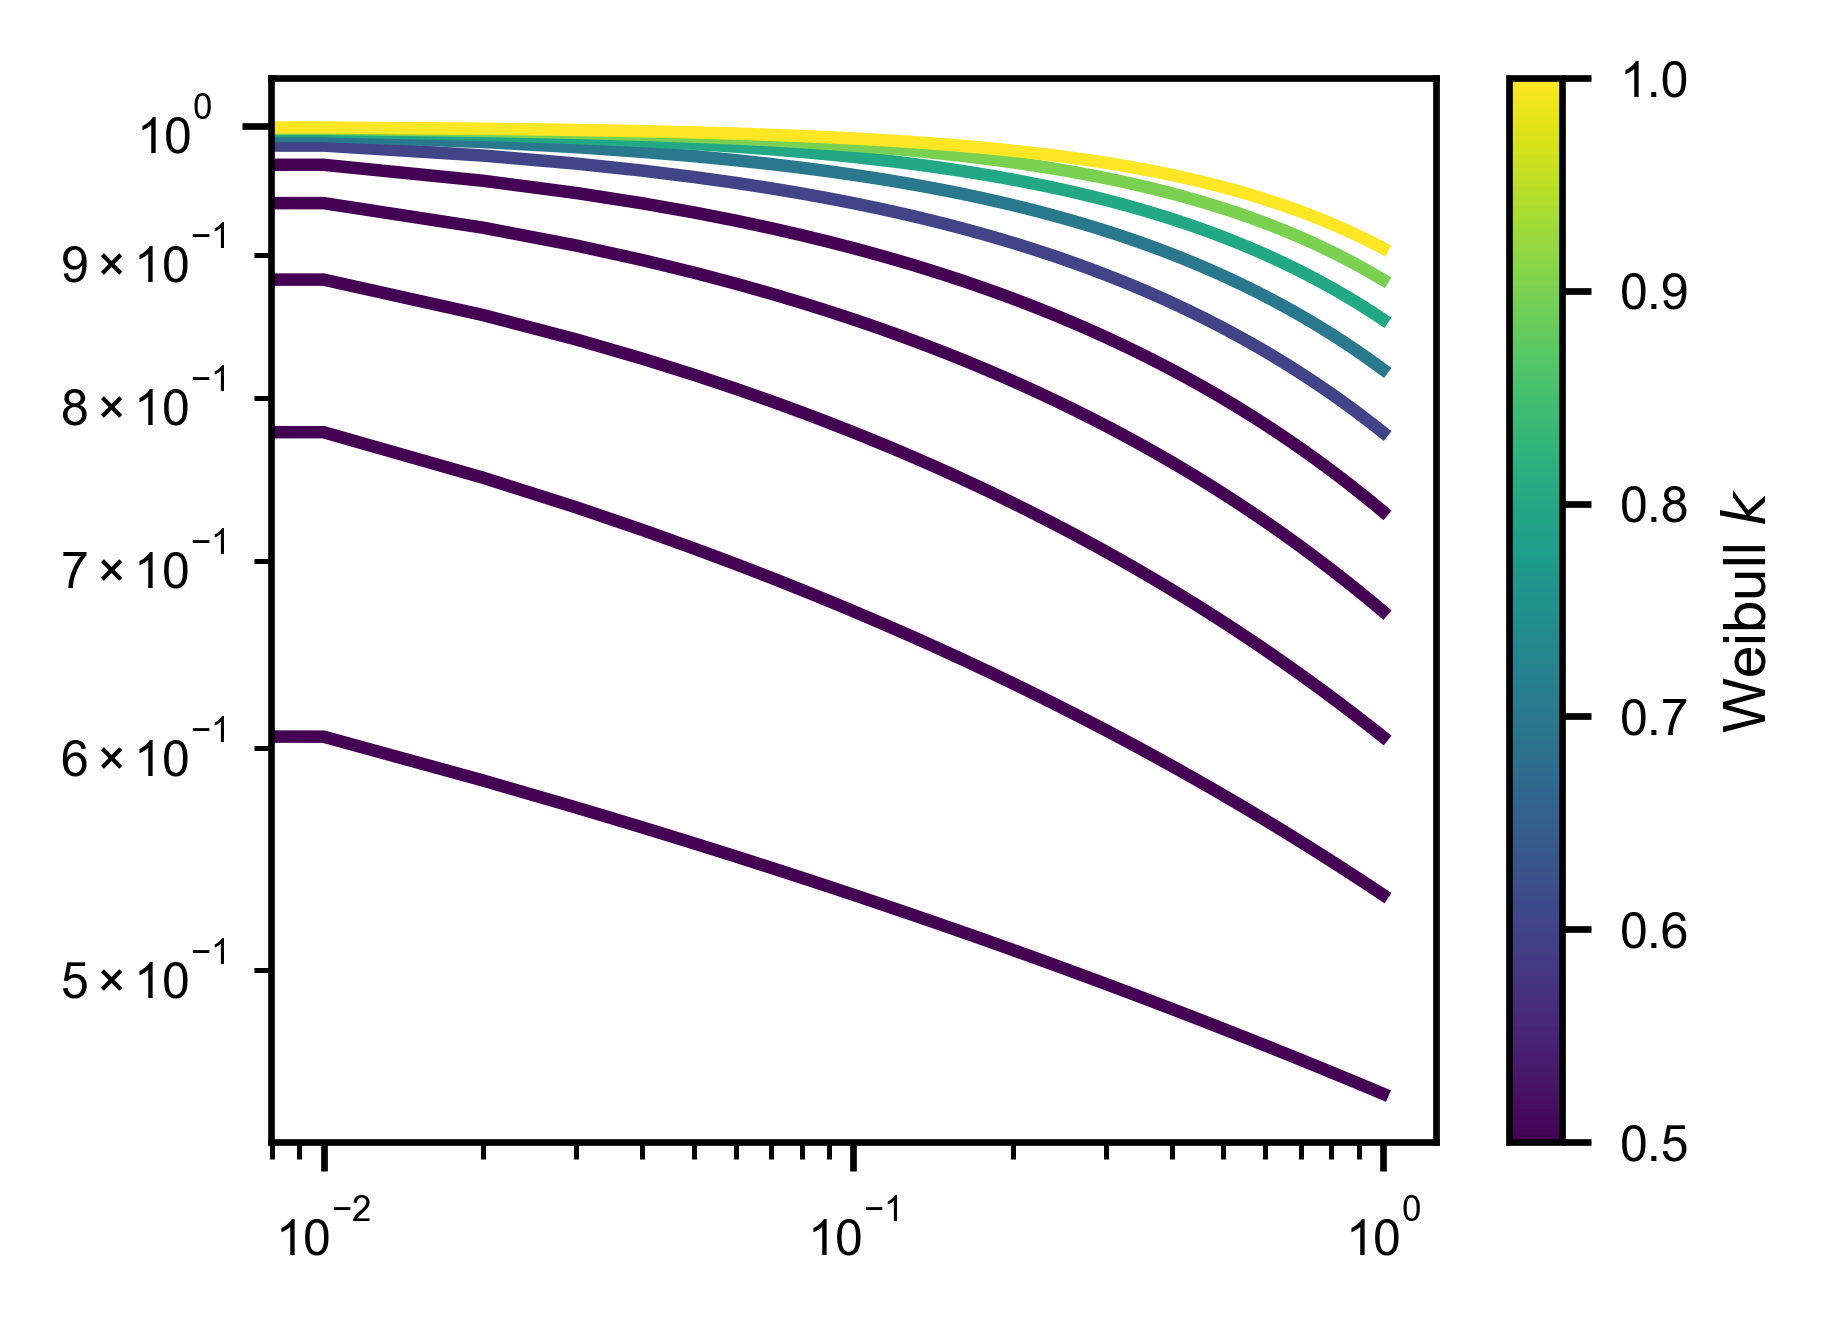

In [61]:
t = np.linspace(0, 1, 101)
ks = np.linspace(0, 1, 11)
for k in ks:
    plt.plot(t, 1 - weibull_min(k, scale=10).cdf(t), c=cmap(cnorm(k)))
plt.xscale('log')
plt.yscale('log')
sm = mpl.cm.ScalarMappable(cnorm, cmap)
sm.set_array([])
cb = plt.colorbar(sm)
cb.set_label('Weibull $k$')

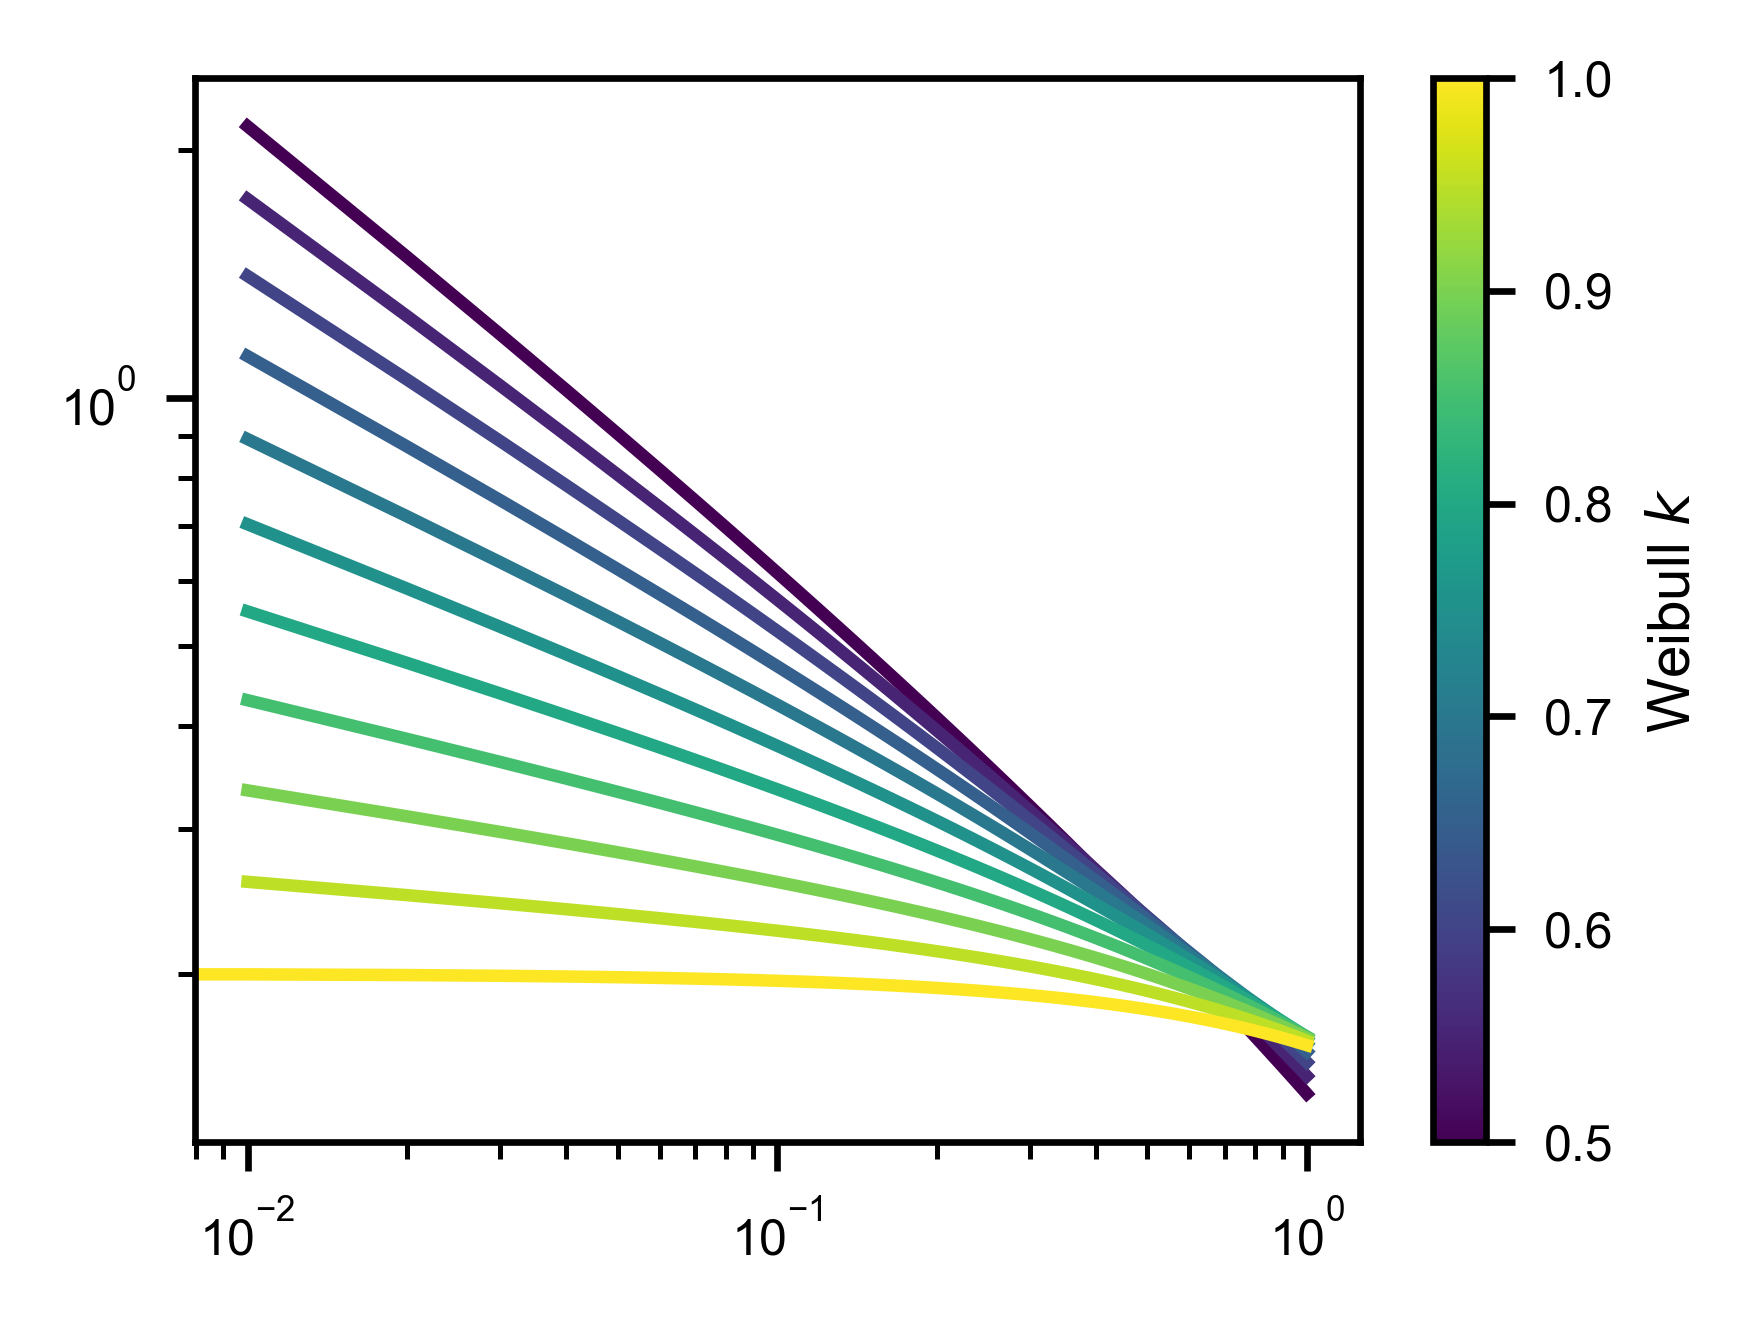

In [46]:
t = np.linspace(0, 1, 101)
ks = np.linspace(0.5, 1, 11)
cnorm = mpl.colors.Normalize(0.5, 1)
for k in ks:
    plt.plot(t, weibull_min(k, scale=5).pdf(t), c=cmap(cnorm(k)))
plt.xscale('log')
plt.yscale('log')
sm = mpl.cm.ScalarMappable(cnorm, cmap)
sm.set_array([])
cb = plt.colorbar(sm)
cb.set_label('Weibull $k$')

### Use scaled Weibull, as above

In [62]:
N_traj = 100000
T = 1
weibull_shape = [0.75, 0.5]
weibull_means = [weibull_min(k).mean() for k in weibull_shape]
var_pair = [fplt.Variable(weibull_min(k, scale=10), name=f'10*W({k:0.2g})')
            for k in weibull_shape]

[var.name for var in var_pair]

['10*W(0.75)', '10*W(0.5)']

In [63]:
%%time
sim = fw.ab_window(
    [var.rvs for var in var_pair],
    offset=-100*np.sum([var.mean() for var in var_pair]),
    window_size=T, 
    num_replicates=N_traj,  
    states=[var.name for var in var_pair]
)
obs = fw.sim_to_obs(sim)

CPU times: user 32.9 s, sys: 5.71 s, total: 38.6 s
Wall time: 38.8 s


In [70]:
for var in var_pair:
    interior, windows = fplt._int_win_from_obs(obs, var.name)
    x_int, cdf_int = fw.ecdf_windowed(interior, windows)
#     exterior = fplt._ext_from_obs(obs, var.name)
#     bin_centers, final_cdf = fw.ecdf_combined(exterior, interior, T)
#     correct_slope_est[var.name] = mean_from_exp_cdf(bin_centers, final_cdf)


In [65]:
len(interior)

604

In [66]:
len(exterior)

4962

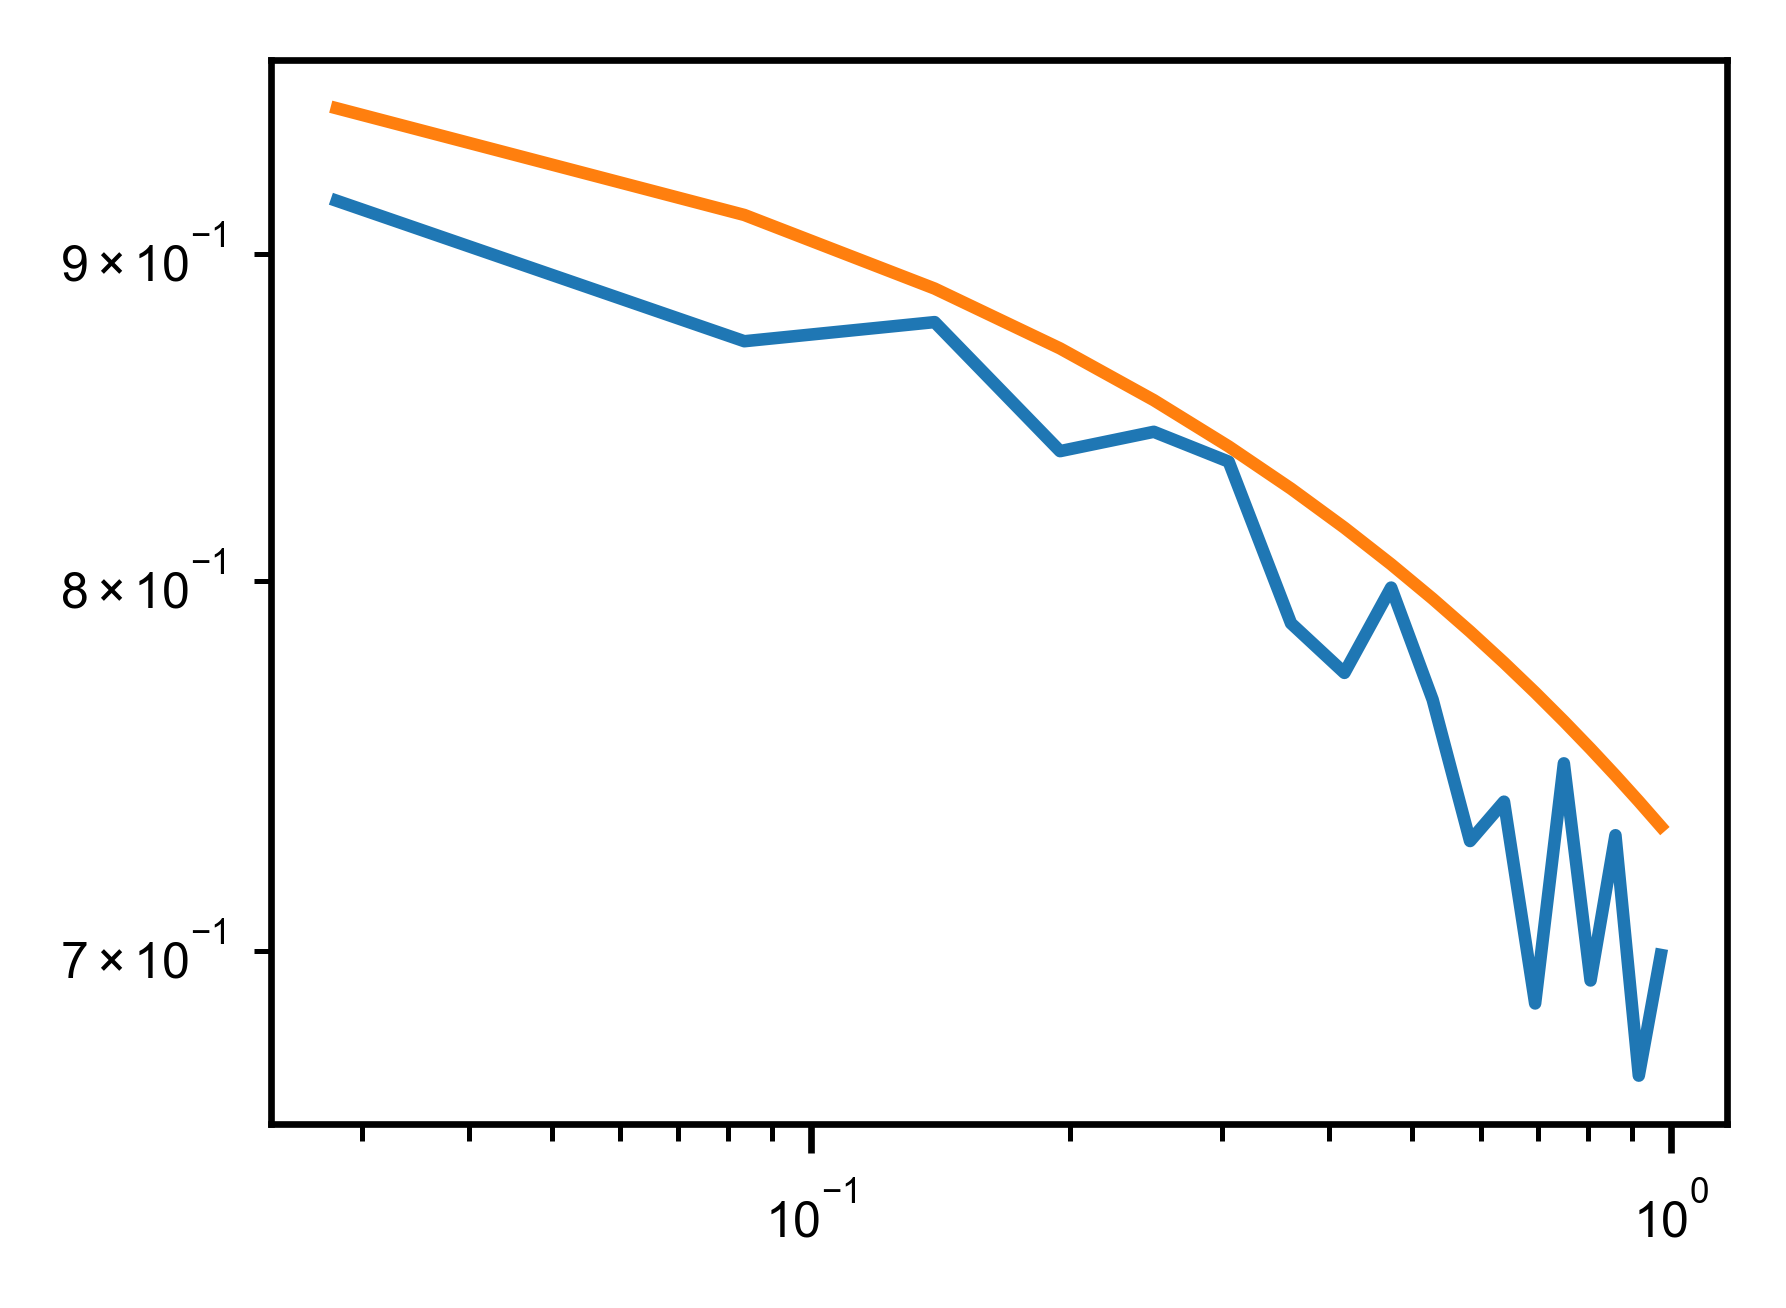

In [67]:
# X, Y = mla.stats.bars_given_discrete_cdf(bin_centers, final_cdf)
plt.plot(bin_centers, 1 - final_cdf)
plt.plot(bin_centers, 1 - var.cdf(bin_centers))
plt.yscale('log')
plt.xscale('log')

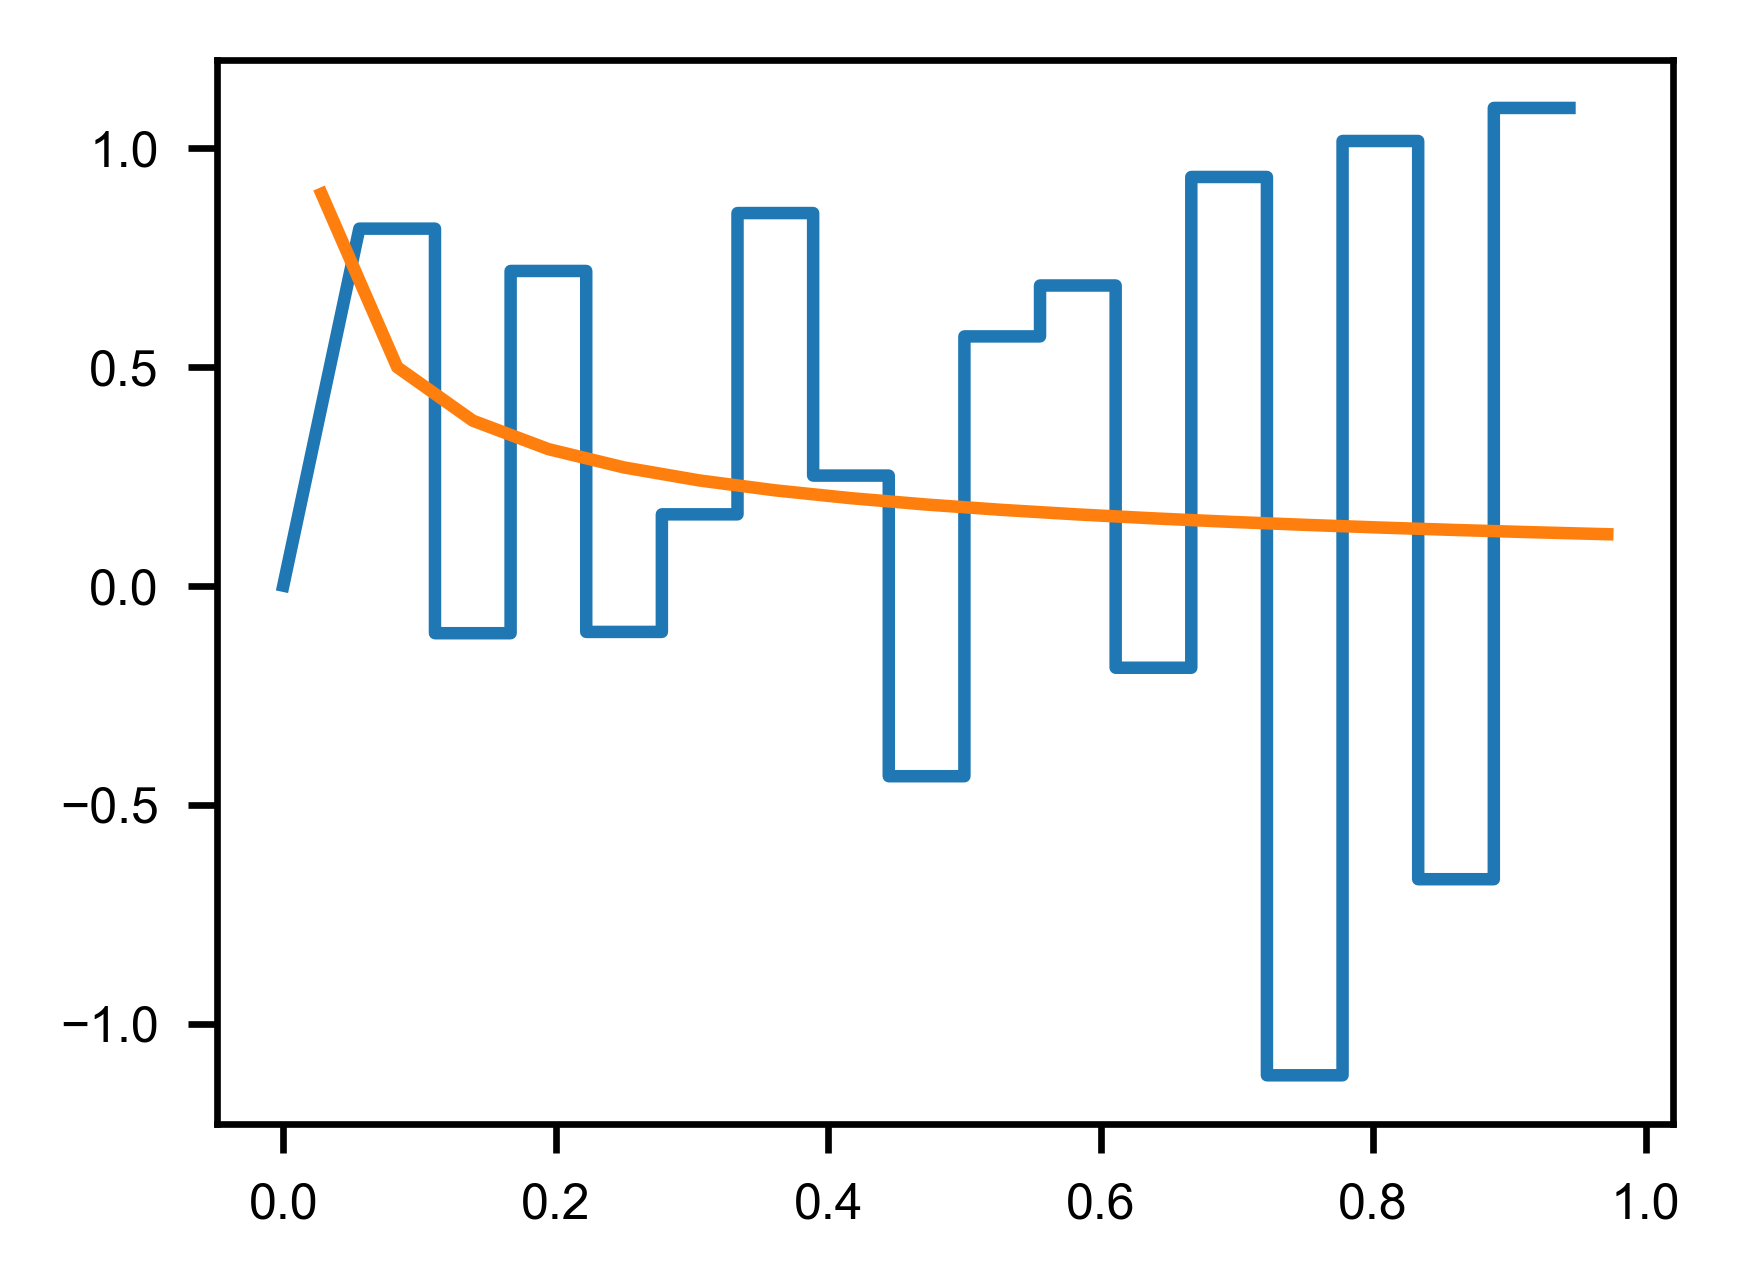

In [69]:
X, Y = mla.stats.bars_given_discrete_cdf(bin_centers, final_cdf)
plt.plot(X, Y)
plt.plot(bin_centers, var.pdf(bin_centers))
# plt.yscale('log')
# plt.xscale('log')

### Let's look at Pareto on those intervals

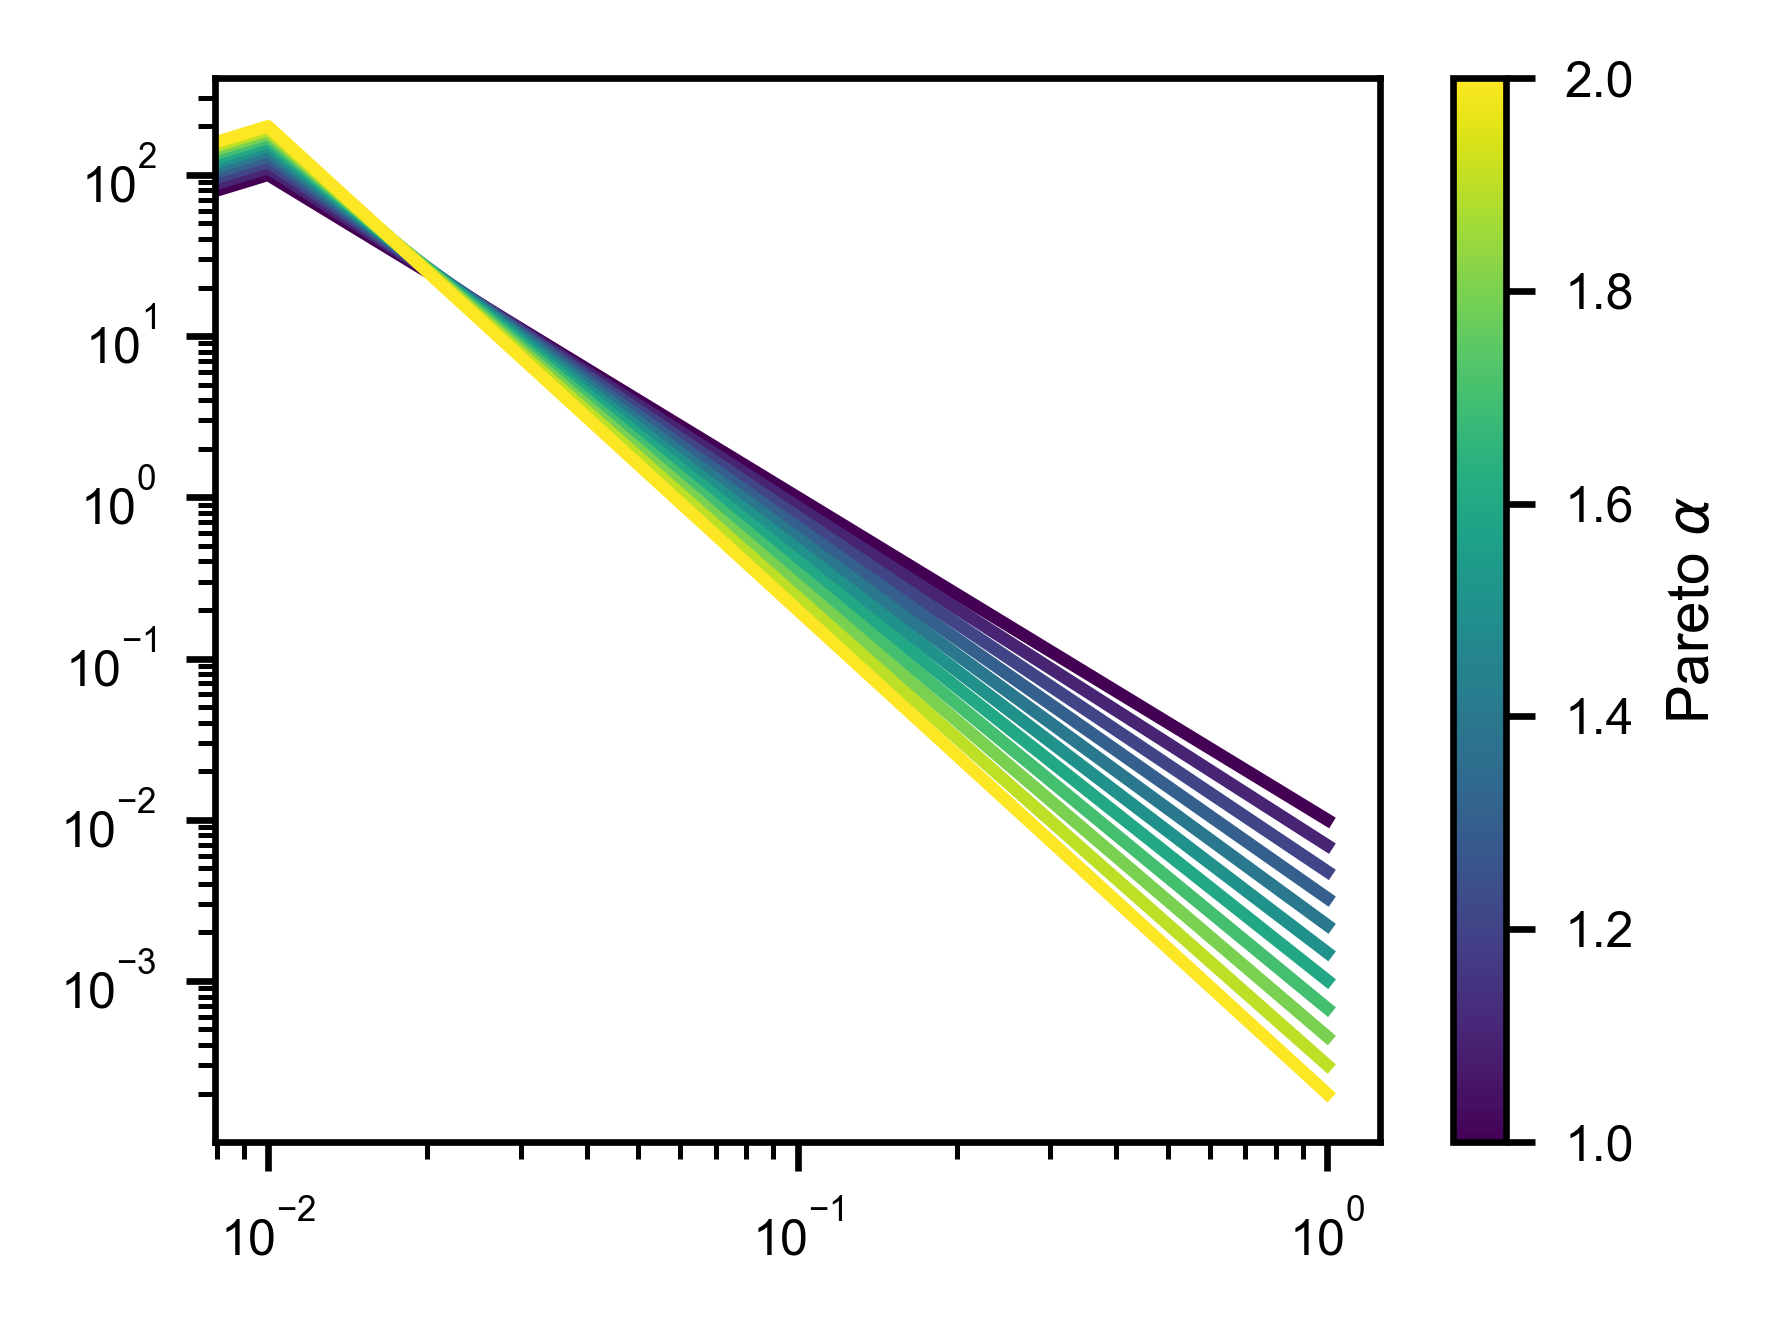

In [96]:
amin, amax = 1, 2

cmap = mpl.cm.get_cmap('viridis')
cnorm = mpl.colors.Normalize(amin, amax)

t = np.linspace(0, 1, 101)
alphas = np.linspace(amin, amax, 11)
for alpha in alphas:
    plt.plot(t, scipy.stats.pareto(alpha, scale=1/100).pdf(t), 
             c=cmap(cnorm(alpha)))
plt.xscale('log')
plt.yscale('log')
sm = mpl.cm.ScalarMappable(cnorm, cmap)
sm.set_array([])
cb = plt.colorbar(sm)
cb.set_label(r'Pareto $\alpha$')

### Use Pareto instead...

In [217]:
importlib.reload(fw.simulation)
importlib.reload(fw)


<module 'multi_locus_analysis.finite_window' from '/home/bbeltr1/developer/multi_locus_analysis/multi_locus_analysis/finite_window/__init__.py'>

In [218]:
%%time
N_boots = np.array([1e5, 1e4, 1e3, 1e2]).astype(int)
N_trajs = np.array([1e2, 1e3, 1e4, 1e5]).astype(int)
for N_boot, N_traj in zip(N_boots, N_trajs):
    fw.bootstrap_alpha_fit_error(N_boot=N_boot, N_traj=N_traj)
    folder = '/home/bbeltr1/Documents/work/ajspakow/finite-window/simulations/'
    utc_time = datetime.datetime.utcnow().strftime('%Y%m%d-%H%M%S')
    file = f'alpha_fit_{N_boot}Nboot_{N_traj}Ntraj-{utc_time}.csv'
    df.to_csv(folder + file)

CPU times: user 1min, sys: 3.07 s, total: 1min 3s
Wall time: 49min 29s


#### Development of slope fit code

quick test that slope fit works

In [163]:
def alpha_from_cdf(x, cdf, xmin):
    xlog = np.log10(x)
    ylog = np.log10(1 - cdf)
    i = (x > xmin) & np.isfinite(xlog) & np.isfinite(ylog)
    # -slope, and +1 because cdf not pdf
    return 1 - scipy.stats.linregress(xlog[i], ylog[i]).slope


In [158]:
for var in var_pair:
    interior, windows = fplt._int_win_from_obs(obs, var.name)
    x_int, cdf_int = fw.ecdf_windowed(interior, windows)
    exterior = fplt._ext_from_obs(obs, var.name)
    bin_centers, final_cdf = fw.ecdf_combined(exterior, interior, T)
#     correct_slope_est[var.name] = mean_from_exp_cdf(bin_centers, final_cdf)


In [164]:
alpha_from_cdf(x_int, cdf_int, xmin)

3.184551153395831

Text(0.5, 1.0, 'Pareto(2)')

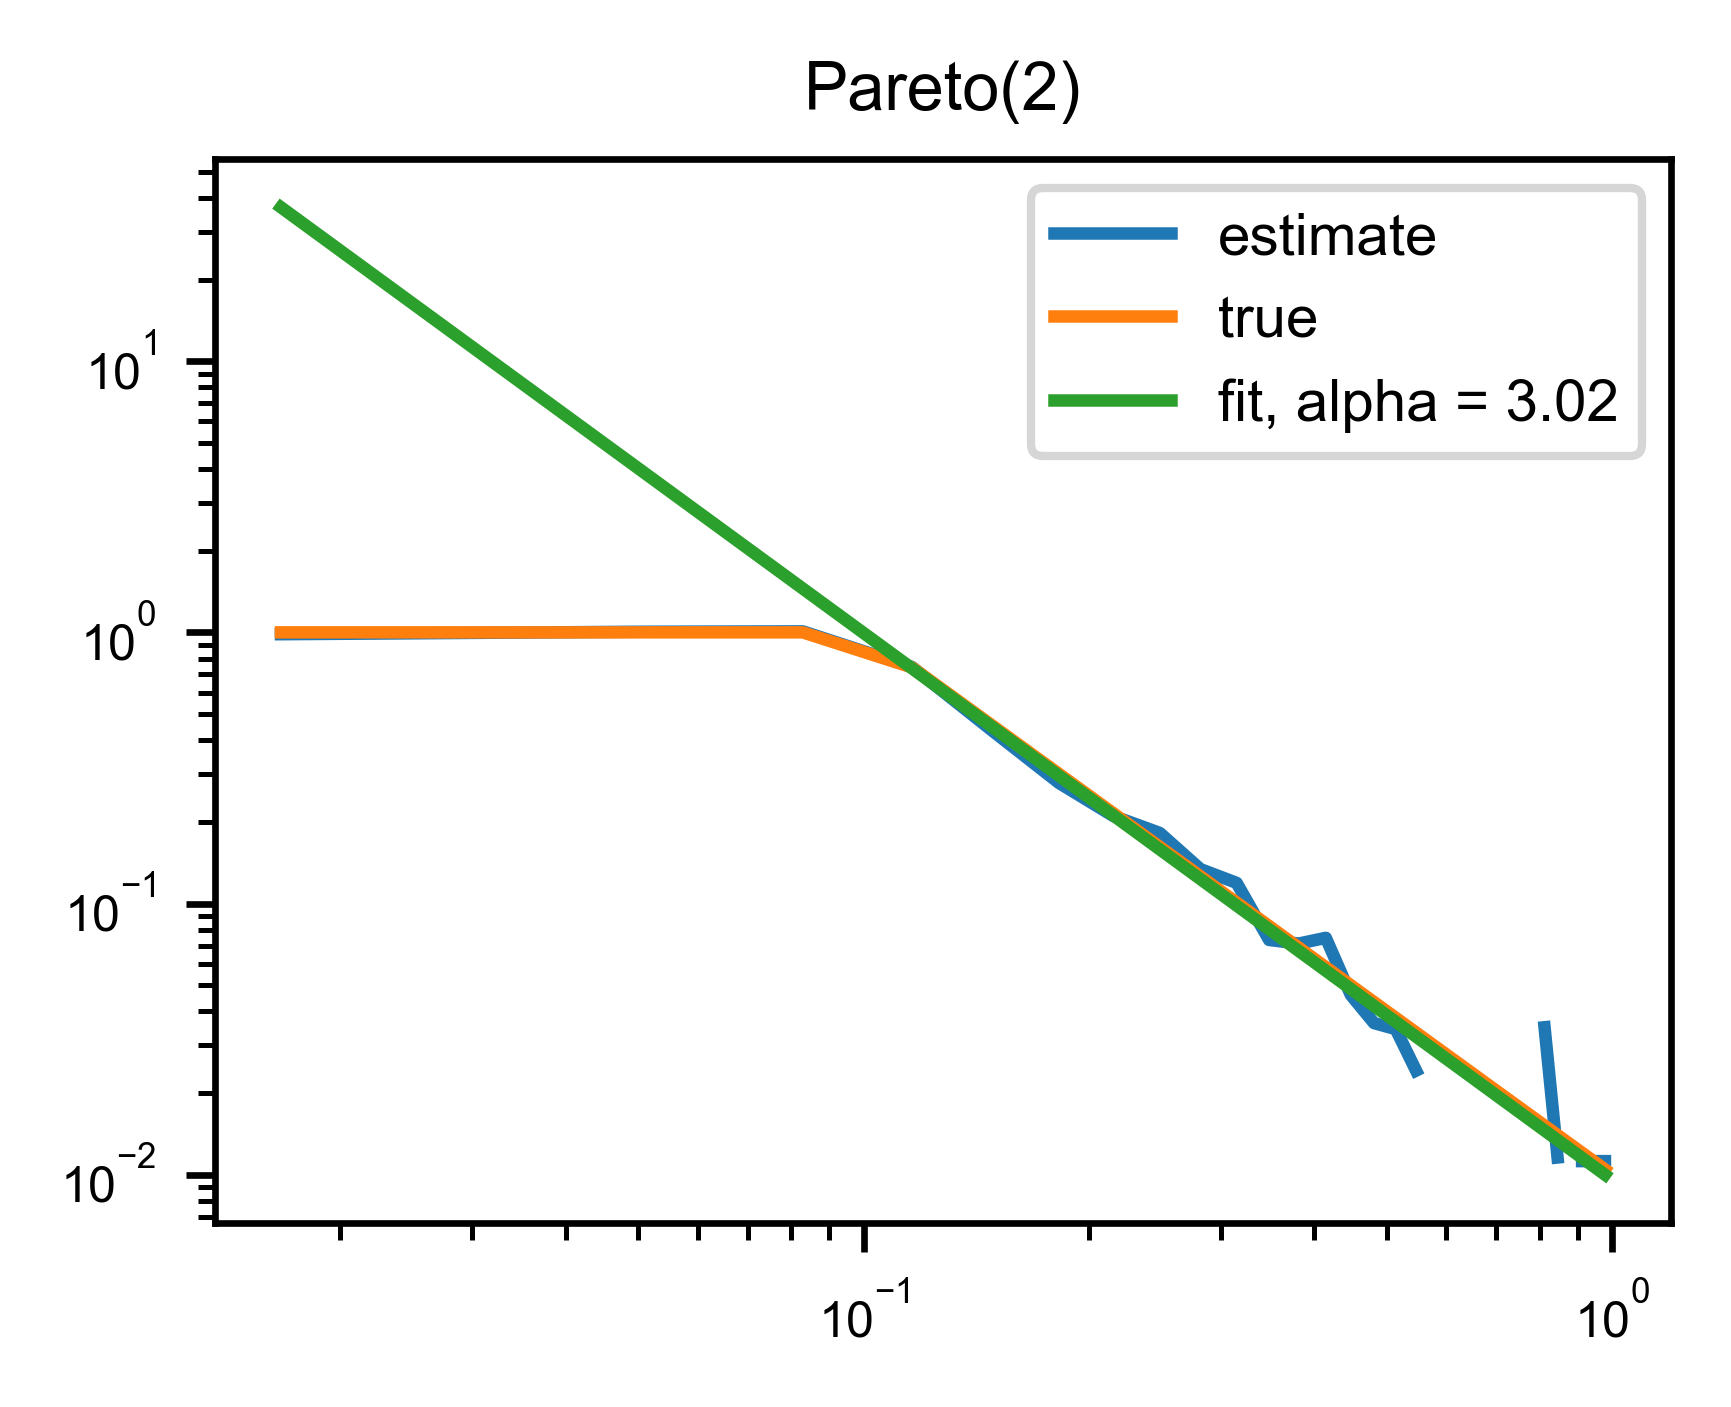

In [146]:
x = bin_centers
y = final_cdf
xlog = np.log10(x)
ylog = np.log10(1 - y)
i = (x > xmin) & np.isfinite(xlog) & np.isfinite(ylog)
slope, intercept, _, _, _, = scipy.stats.linregress(xlog[i], ylog[i])

plt.plot(bin_centers, 1 - final_cdf, label='estimate')
plt.plot(bin_centers, 1 - var.cdf(bin_centers), label='true')
fitX = np.log10(bin_centers)
fitY = slope*fitX + intercept
plt.plot(bin_centers, 10**fitY, label=f'fit, alpha = {1-slope:0.03g}')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title(var.name)

In [152]:
num_obs = len(interior)
uncensored_obs = var.rvs(size=(num_obs,))
mla.stats.power_law_slope_mle(uncensored_obs, xmin, num_obs)

3.016161993325317

In [168]:
import lifelines
import pandas as pd

In [178]:
true_alpha = {var.name: var.args[0] + 1 for var in var_pair}
mle_interior_est = {}
mle_uncensored_baseline = {}
fit_interior = {}
fit_corrected = {}
fit_kaplan = {}
fit_uncensored_baseline = {}
for var in var_pair:
    # mle, interior
    interior, windows = fplt._int_win_from_obs(obs, var.name)
    num_obs = len(interior)
    mle_interior_est[var.name] = mla.stats.power_law_slope_mle(
        interior, xmin, num_obs)
    # fit, interior
    x_int, cdf_int = fw.ecdf_windowed(interior, windows)
    fit_interior[var.name] = alpha_from_cdf(x_int, cdf_int, xmin)
    # fit, corrected
    exterior = fplt._ext_from_obs(obs, var.name)
    bin_centers, final_cdf = fw.ecdf_combined(exterior, interior, T)
    fit_corrected[var.name] = alpha_from_cdf(bin_centers, final_cdf, xmin)
    # fit, kaplan
    times = np.concatenate([interior, exterior])
    is_interior = np.concatenate(
        [np.ones_like(interior), np.zeros_like(exterior)]
    ).astype(bool)
    kmf = lifelines.KaplanMeierFitter() \
        .fit(times, event_observed=is_interior)
    x_kap = kmf.cumulative_density_.index.values
    cdf_kap = kmf.cumulative_density_.values.flatten()
    fit_kaplan[var.name] = alpha_from_cdf(x_kap, cdf_kap, xmin)
    # mle, uncensored baseline
    uncensored_obs = var.rvs(size=(num_obs,))
    mle_uncensored_baseline[var.name] = mla.stats.power_law_slope_mle(
        uncensored_obs, xmin, num_obs)
    # fit, uncensored baseline
    x_unc, cdf_unc = mla.stats.ecdf(uncensored_obs, pad_left_at_x=0)
    fit_uncensored_baseline[var.name] = \
        alpha_from_cdf(x_unc, cdf_unc, xmin)
df = pd.concat(
    map(
        pd.Series, 
        [true_alpha, mle_interior_est, mle_uncensored_baseline,
         fit_interior, fit_corrected, fit_kaplan, 
         fit_uncensored_baseline]
    ), axis=1
)
df.columns = ['true', 'mle-interior', 'mle-uncensored', 'fit-interior', 
              'fit-corrected', 'fit-kaplan', 'fit-uncensored']
df["N_boot"] = N_boot
df["N_traj"] = N_traj

## Examples residuals across trajectory

In [15]:
Nboot_Ntraj = [(10**(6-k), 10**k) for k in [3, 4, 5]]
Nboot_Ntraj

[(1000, 1000), (100, 10000), (10, 100000)]

In [ ]:
%%time
err_aves = []
err_stds = []
for N_boot, N_traj_per_boot in Nboot_Ntraj:
    err_t, err_ave, err_std = fw.bootstrap_int_error(
        var_pair, T, N_boot, N_traj_per_boot
    )
    err_aves.append(err_ave)
    err_stds.append(err_std)

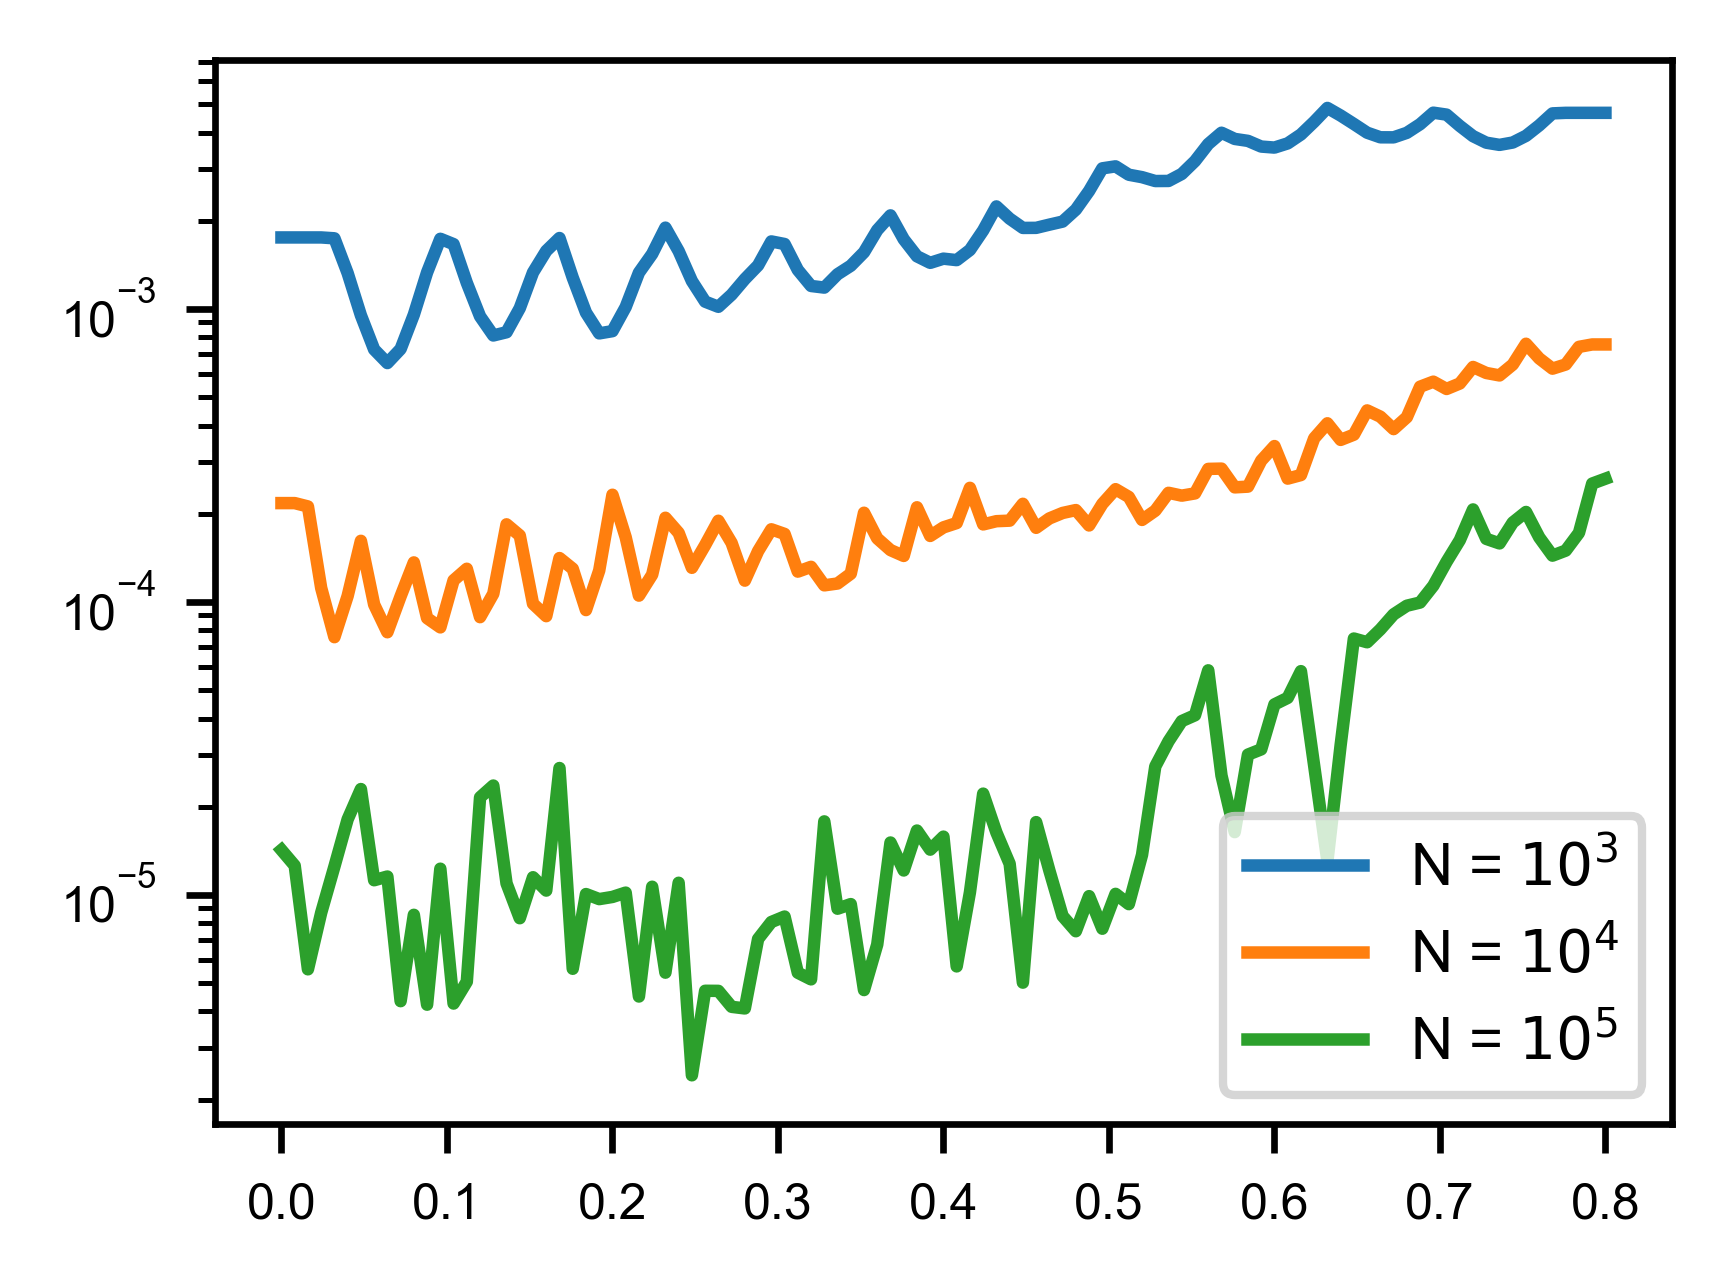

In [58]:
import matplotlib.pyplot as plt
for i, (N_boot, N_traj_per_boot) in enumerate(Nboot_Ntraj):
#     err_ave = err_aves[i]
    err_std = err_stds[i][var_pair[0].name]
    plt.plot(err_t, err_std, label=f'N = $10^{np.log10(N_traj_per_boot).astype(int)}$')
plt.yscale('log')
plt.legend()

In [ ]:
plt.plot(scipy)

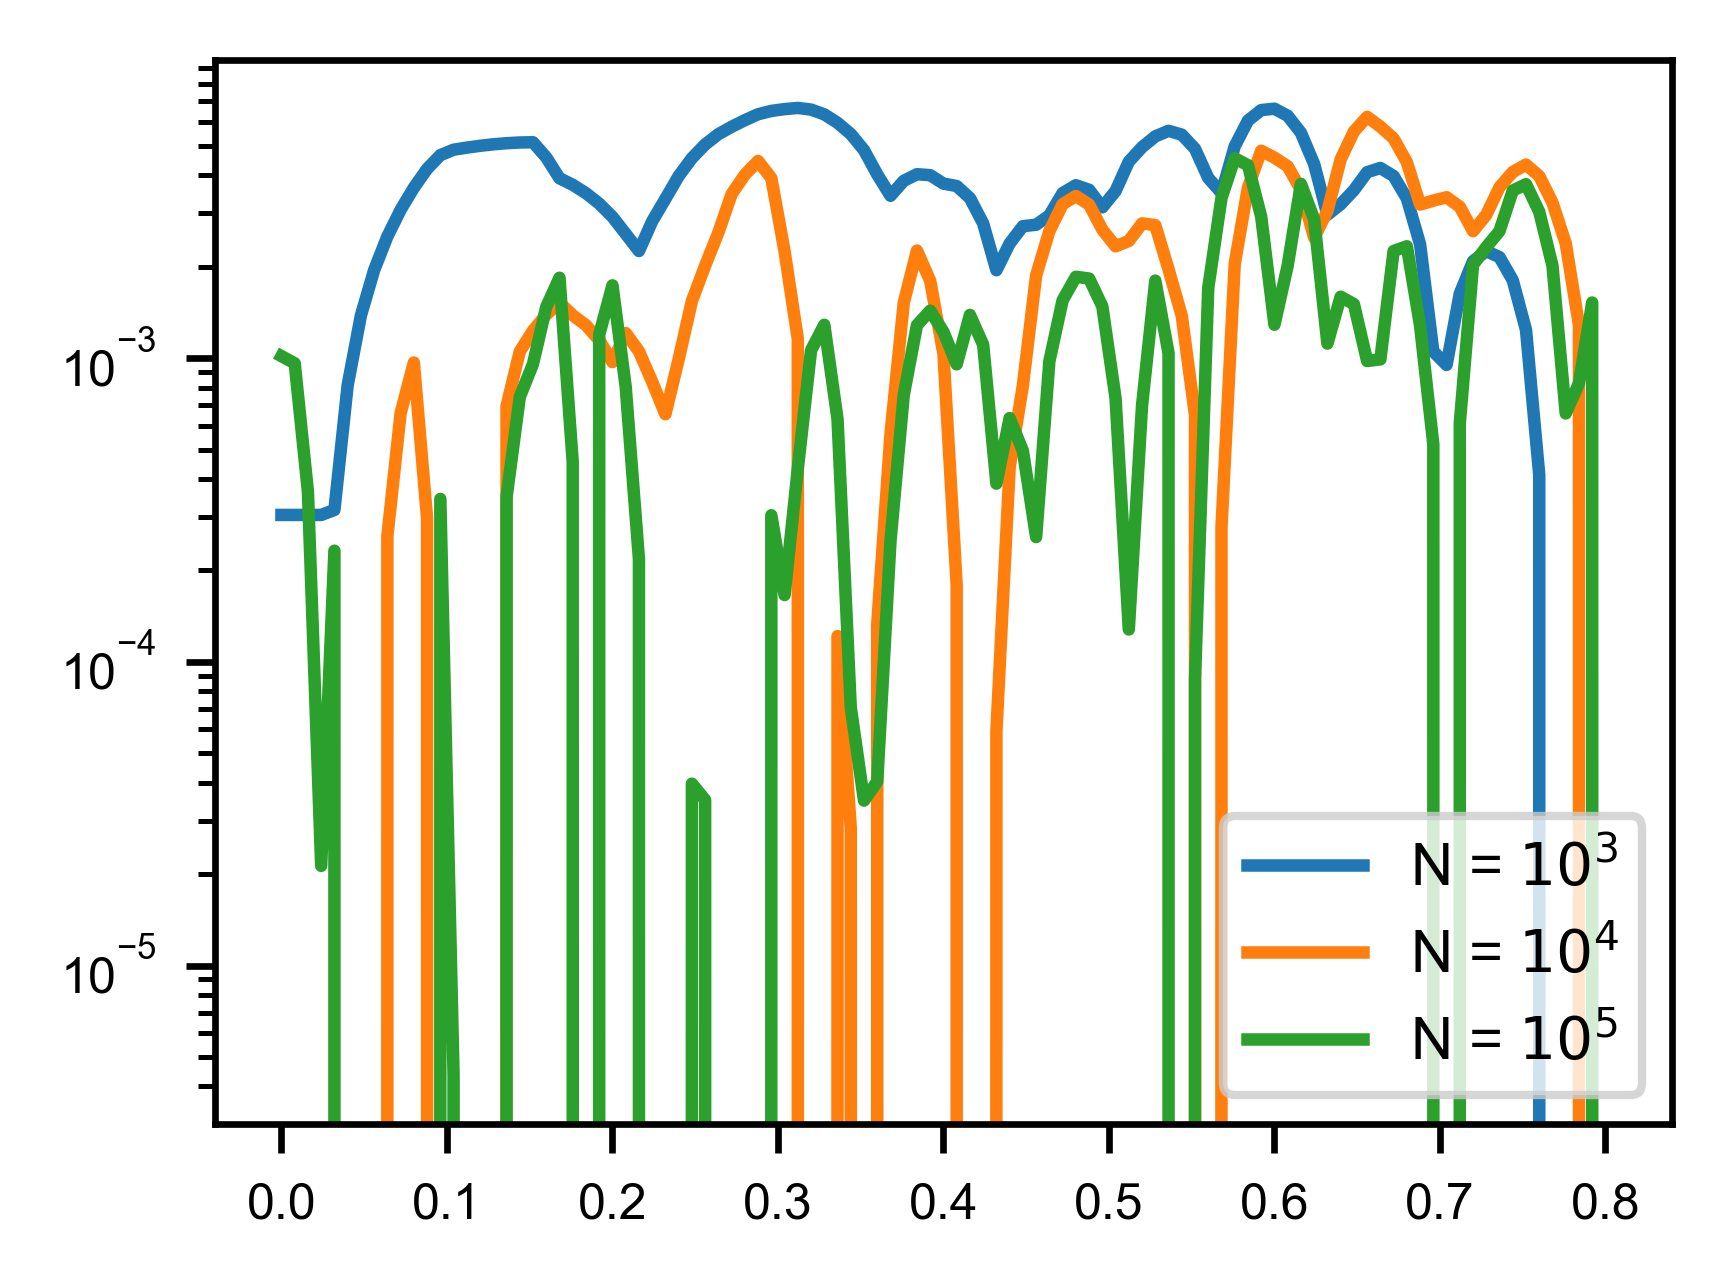

In [63]:
for i, (N_boot, N_traj_per_boot) in enumerate(Nboot_Ntraj):
    err_ave = err_aves[i][var_pair[0].name]
#     err_std = err_stds[i][var_pair[0].name]
    plt.plot(err_t, -err_ave, label=f'N = $10^{np.log10(N_traj_per_boot).astype(int)}$')
plt.yscale('log')
plt.legend()

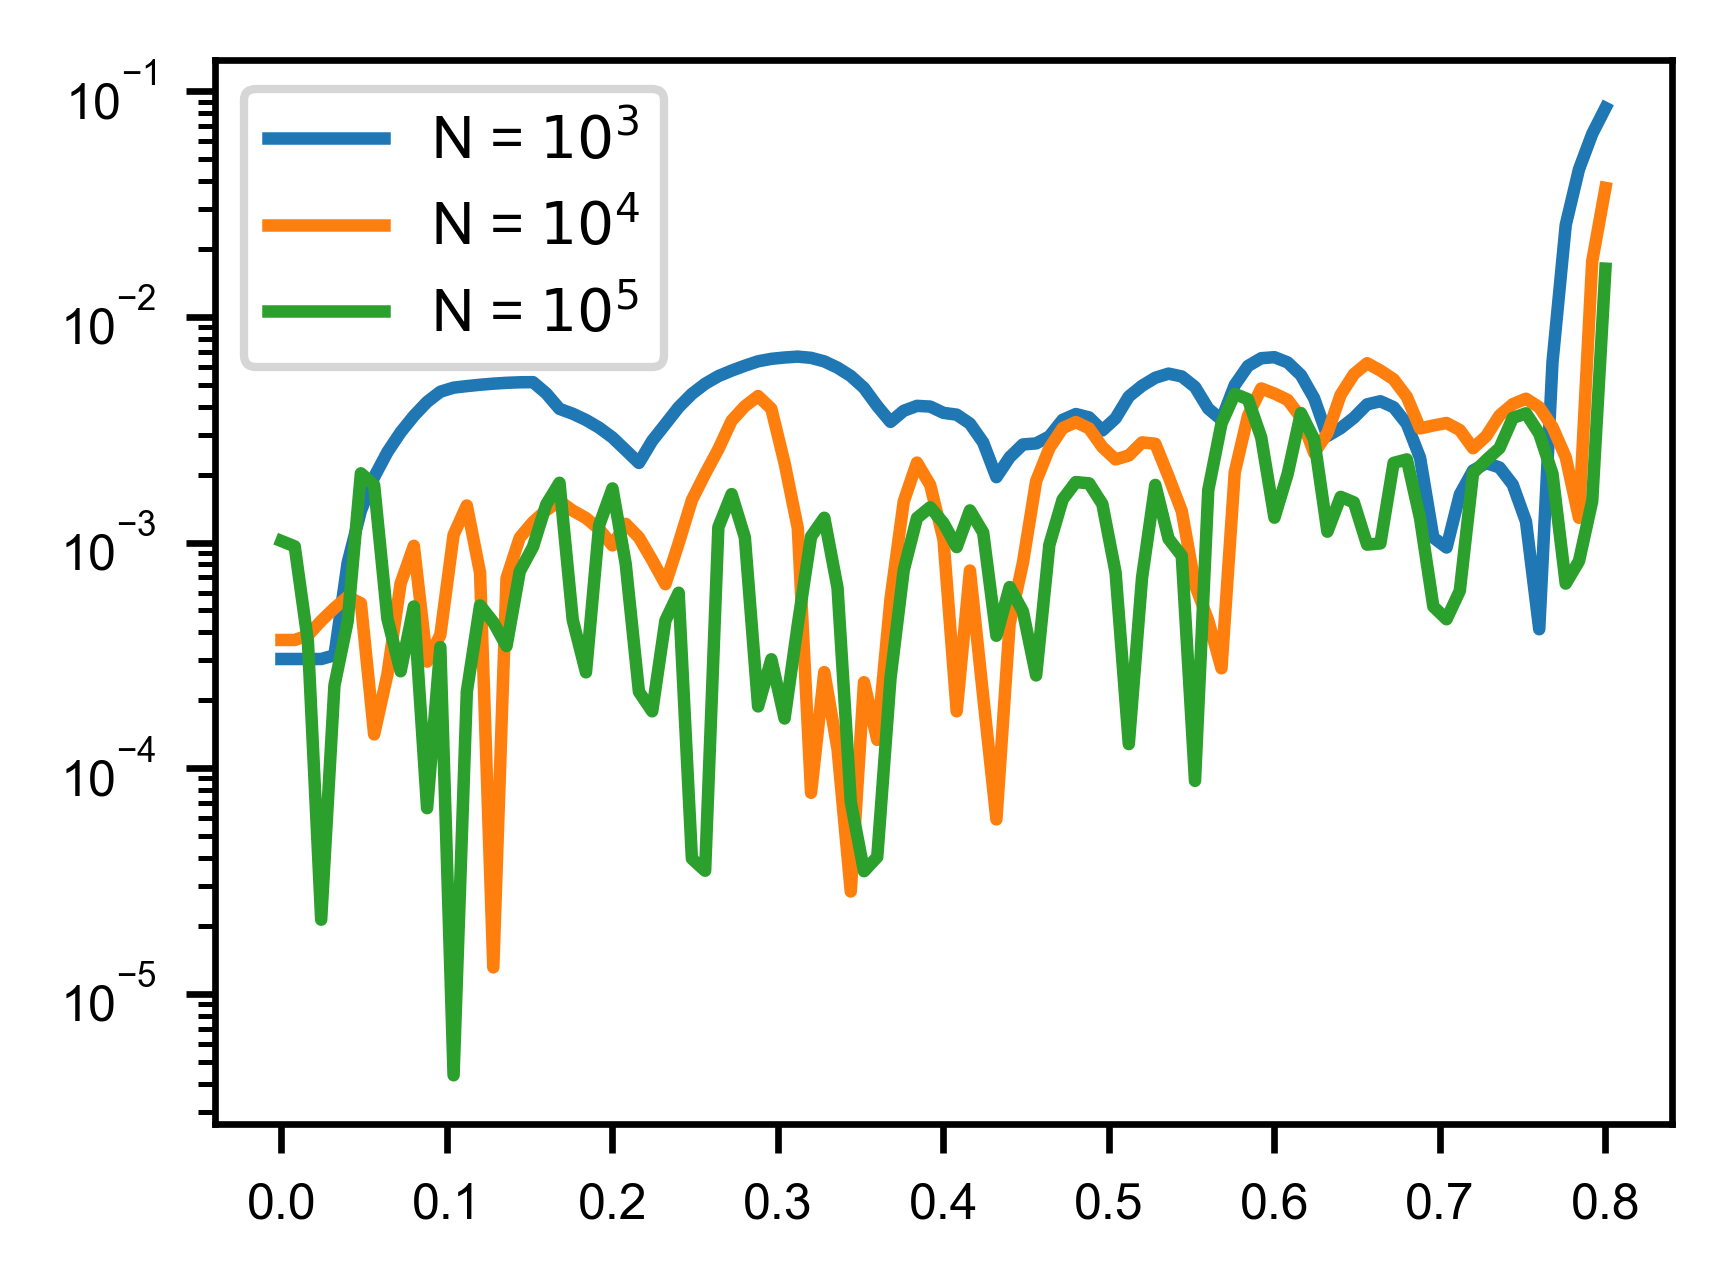

In [62]:
for i, (N_boot, N_traj_per_boot) in enumerate(Nboot_Ntraj):
    err_ave = err_aves[i][var_pair[0].name]
#     err_std = err_stds[i][var_pair[0].name]
    plt.plot(err_t, np.abs(err_ave), label=f'N = $10^{np.log10(N_traj_per_boot).astype(int)}$')
plt.yscale('log')
plt.legend()

## Old runs

large number of bootstraps...

In [47]:
import pickle

In [50]:
with open('/home/bbeltr1/Downloads/int_err_boot_1000_traj.pkl', 'wb') as f:
    pickle.dump((err_ave, err_std), f)

In [70]:
with open('/home/bbeltr1/Downloads/int_err_boot_1000_traj.pkl', 'rb') as f:
    err_ave, err_std = pickle.load(f)

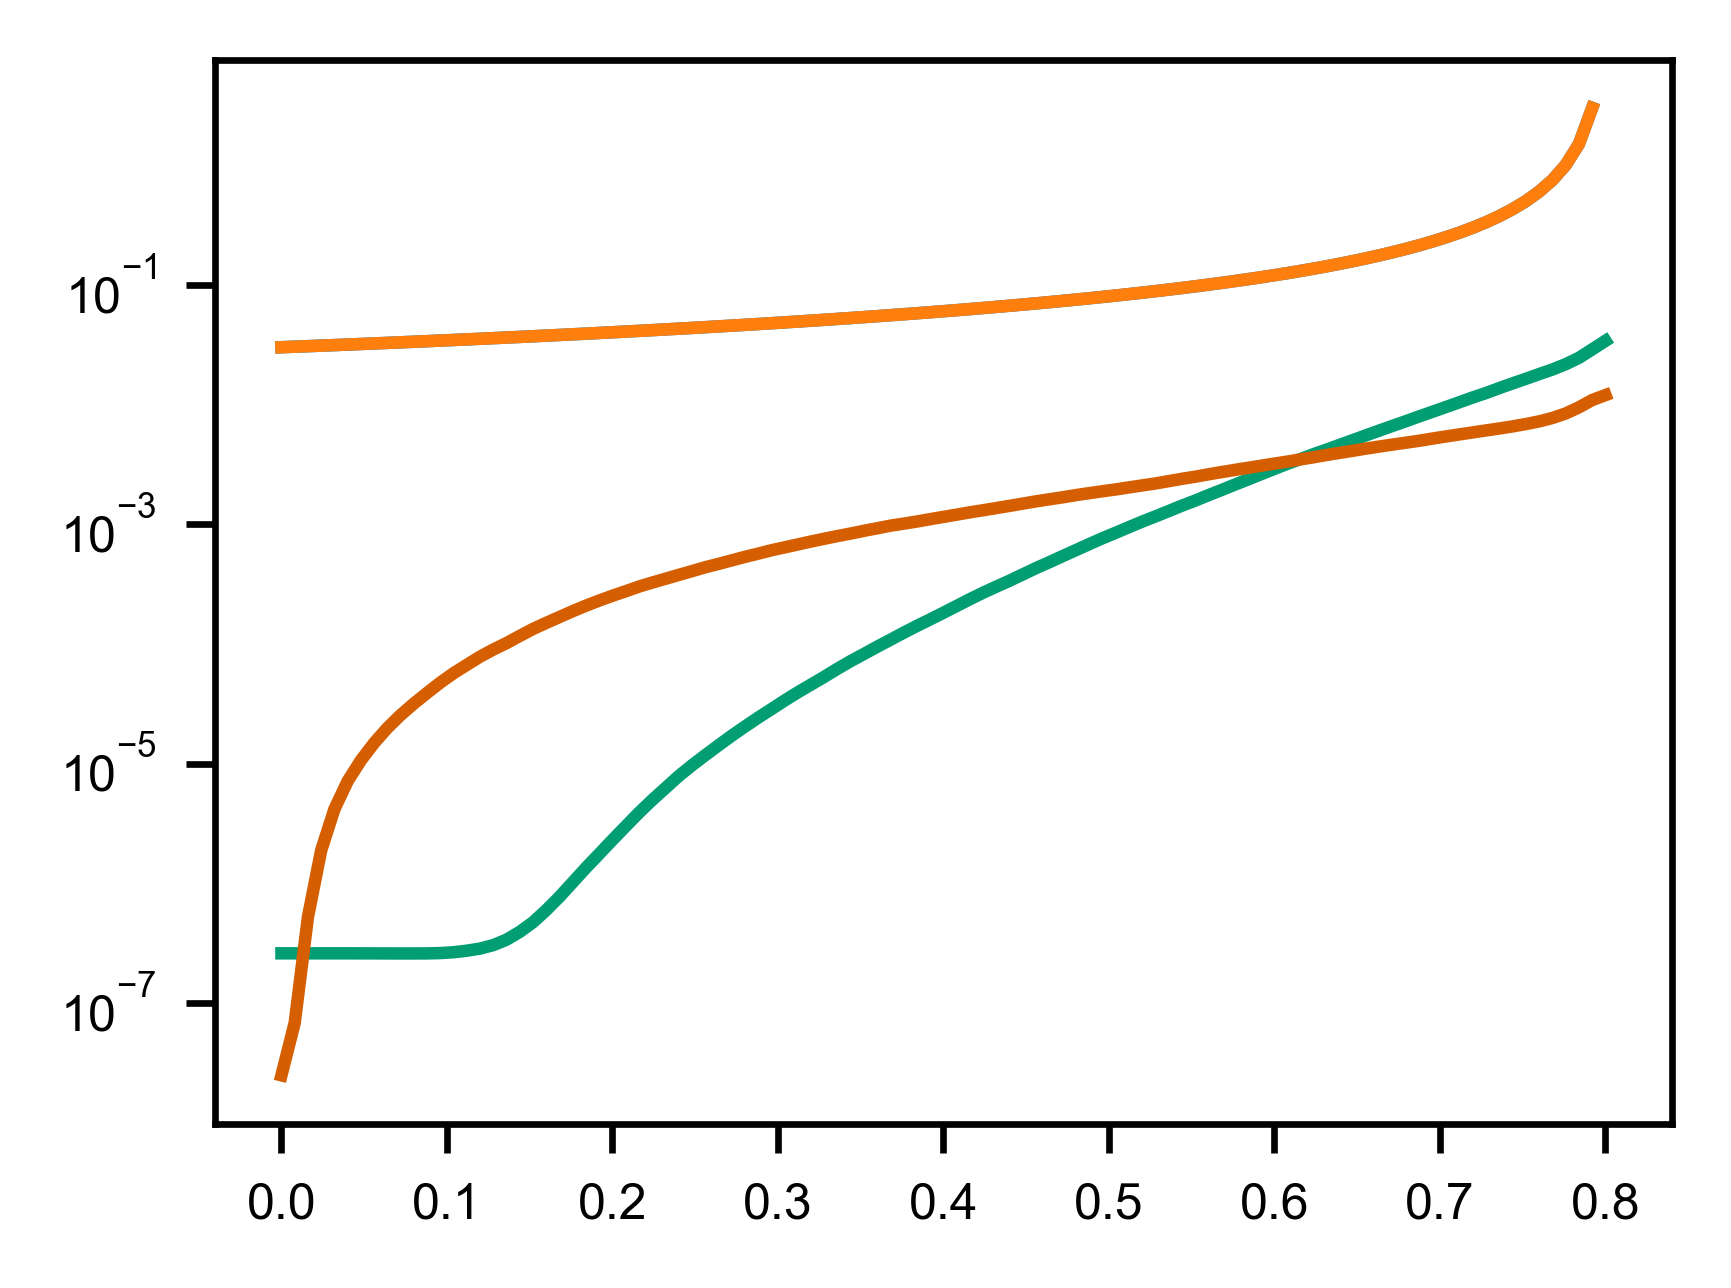

In [80]:
for var in var_pair:
    plt.plot(err_t, err_std[var.name], color=var.color)
    plt.plot(err_t, dfw_e*T/(T - err_t))
    plt.yscale('log')


(0.0001, 0.1)

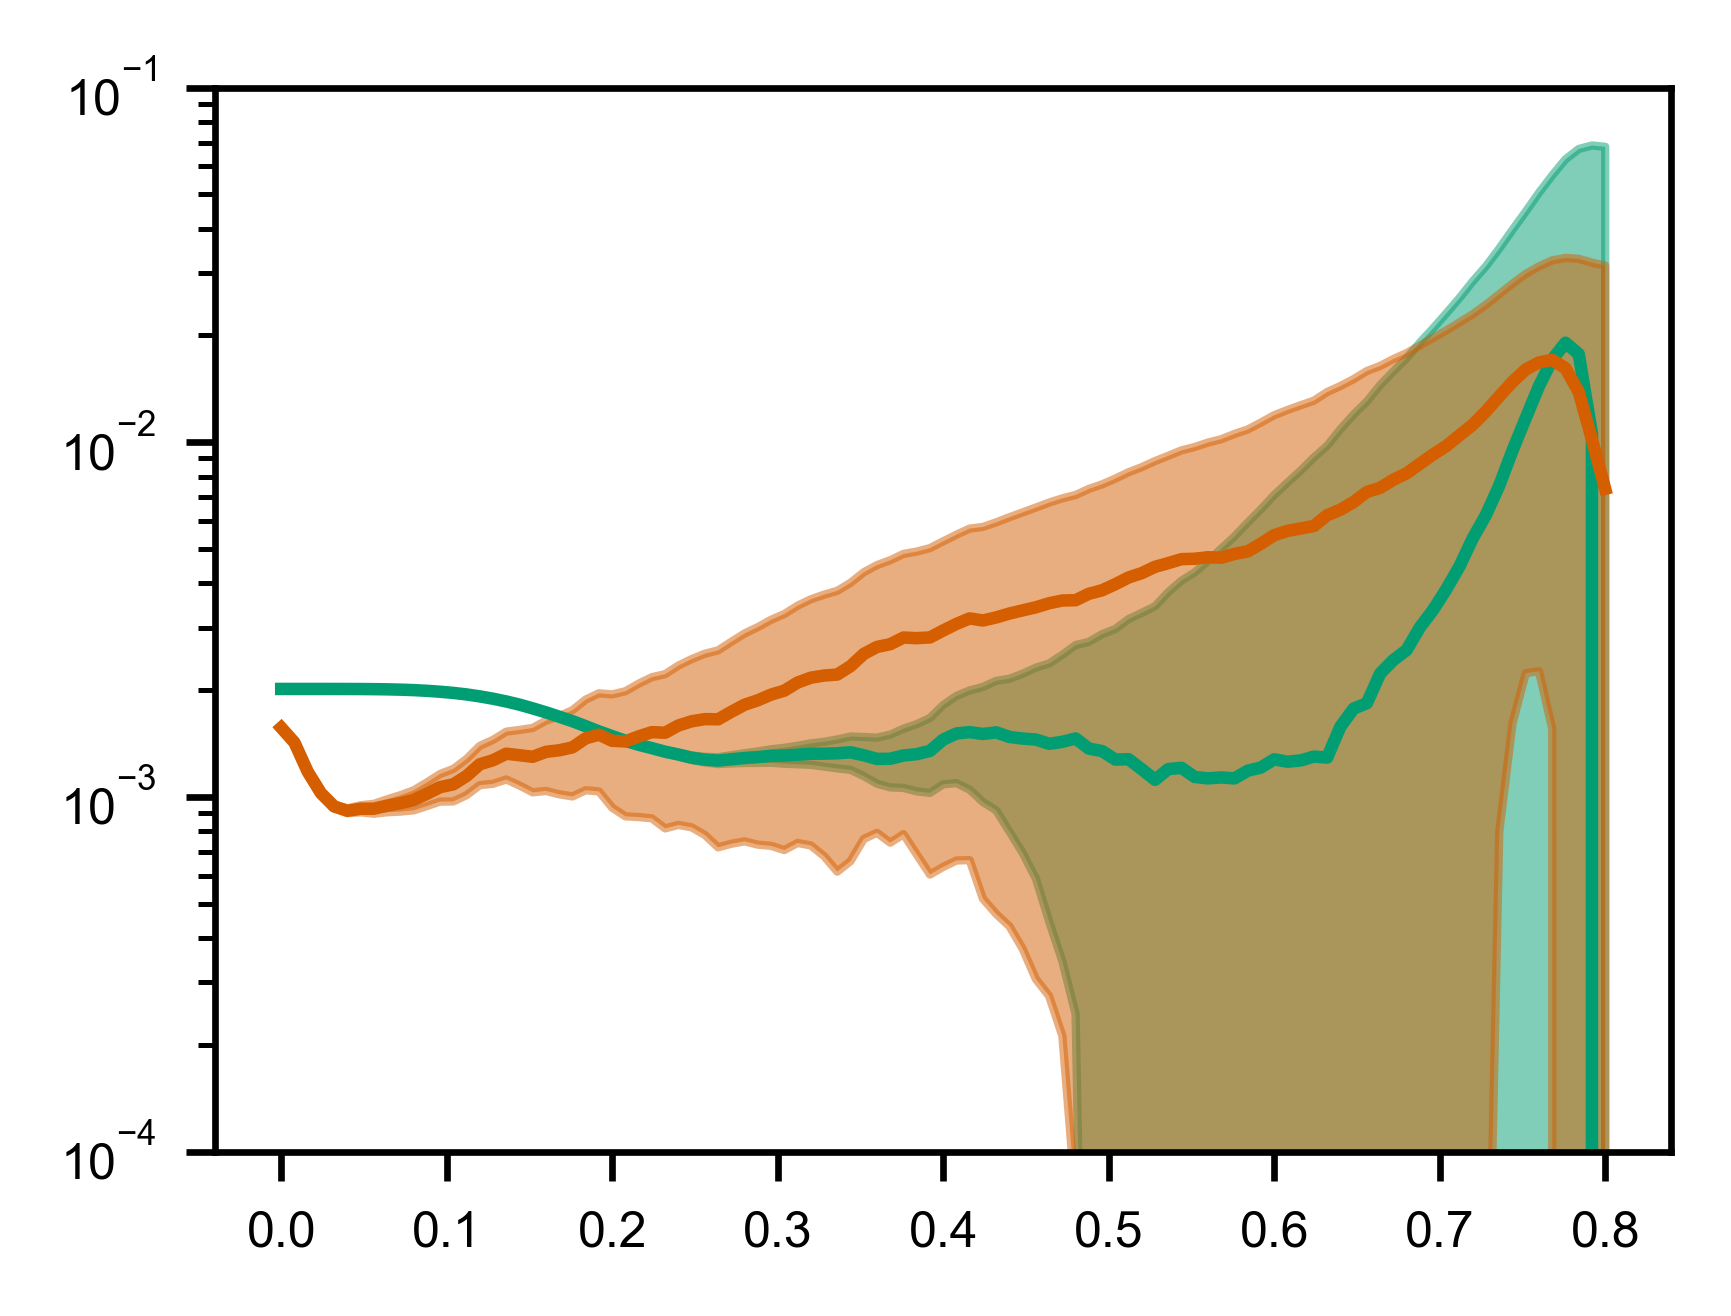

In [71]:
fig, ax = plt.subplots()
for var in var_pair:
    ax.plot(err_t, -err_ave[var.name], c=var.color)
    ax.fill_between(
        err_t, 
        -err_ave[var.name] - 2*err_std[var.name],
        -err_ave[var.name] + 2*err_std[var.name],
        alpha=0.5,
        color=var.color
    )
plt.yscale('log')
plt.ylim([1e-4, 1e-1])

In [85]:
observation = fw.sim_to_obs(sim)

In [96]:
N_per_subboot = 1000
replicates = observation.index.get_level_values('replicate').unique().values
num_replicates = len(replicates)
obs = observation.reset_index(level=1).loc[np.random.randint(num_replicates, size=(N_per_subboot,))]

In [97]:
obs

rank_order       state  start_time  end_time  wait_time  \
replicate                                                            
120                 1  Beta(2, 2)    0.000000  0.263928   0.263928   
120                 2  Beta(5, 2)    0.263928  0.800000   0.536072   
288                 1  Beta(5, 2)    0.000000  0.338358   0.338358   
288                 2  Beta(2, 2)    0.338358  0.502808   0.164450   
288                 3  Beta(5, 2)    0.502808  0.800000   0.297192   
...               ...         ...         ...       ...        ...   
401                 1  Beta(2, 2)    0.000000  0.449426   0.449426   
401                 2  Beta(5, 2)    0.449426  0.800000   0.350574   
972                 1  Beta(2, 2)    0.000000  0.714282   0.714282   
972                 2  Beta(5, 2)    0.714282  0.800000   0.085718   
223                 1  Beta(5, 2)    0.000000  0.800000   0.800000   

           window_size  num_waits       wait_type  
replicate                                          
120                0.8          2   left exterior  
120                0.8          2  right exterior  
288                0.8          3   left exterior  
288                0.8          3        interior  
288                0.8          3  right exterior  
...                ...        ...             ...  
401                0.8          2   left exterior  
401                0.8          2  right exterior  
972                0.8          2   left exterior  
972                0.8          2  right exterior  
223                0.8          1   full exterior  

[2328 rows x 8 columns]

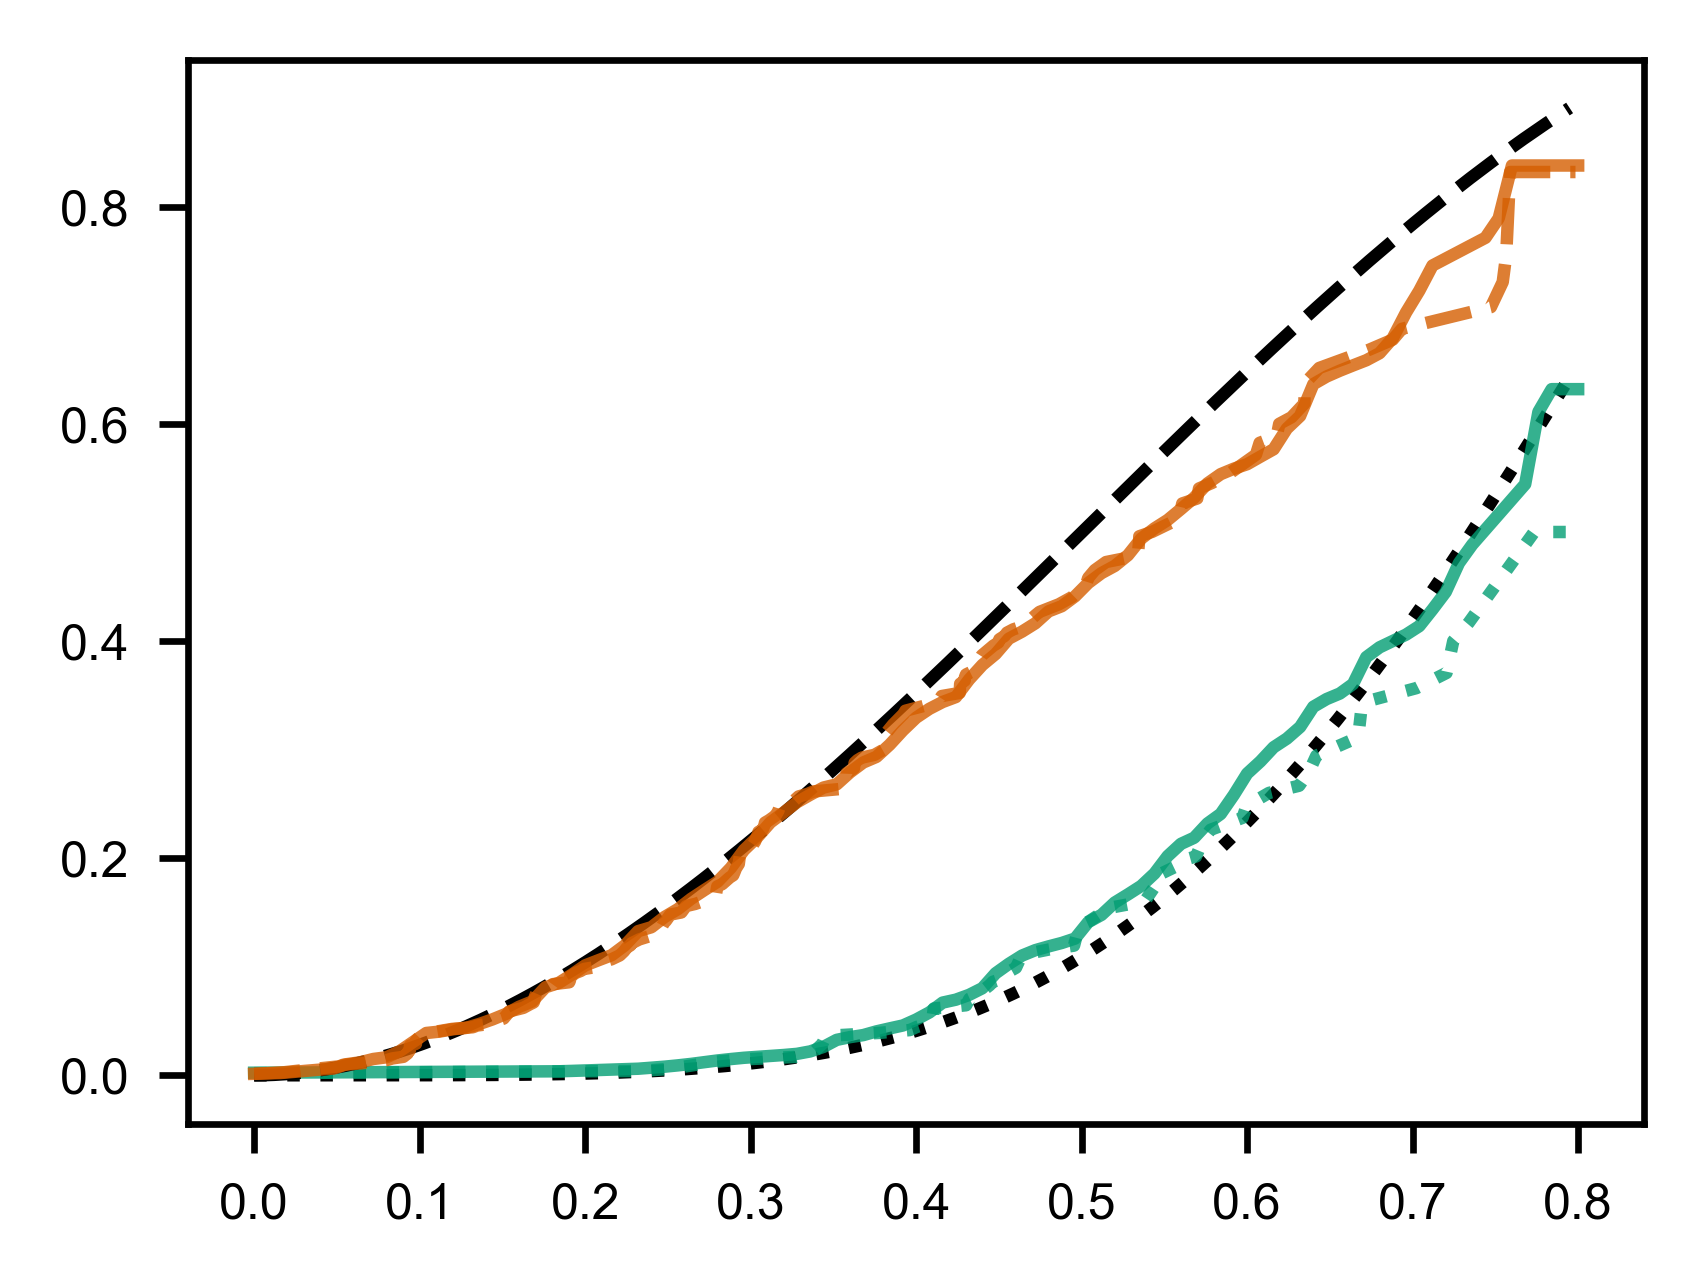

In [101]:
stats = mla.stats
traj_cols = ['replicate']
sim = fw.ab_window(
    [var.rvs for var in var_pair],
    offset=-100*np.sum([var.mean() for var in var_pair]),
    window_size=T, 
    num_replicates=1_000,  
    states=[var.name for var in var_pair]
)
observation = fw.sim_to_obs(sim)

shared_t = np.linspace(0, T, 101)
est = {var.name: np.zeros_like(shared_t) for var in var_pair}
saved_all_times = {}
saved_int_est = {}
N_subboot = 100
N_per_subboot = 1000

for i in range(N_subboot):
    replicates = observation.index \
        .get_level_values('replicate').unique().values
    num_replicates = len(replicates)
    obs = observation.reset_index(level=1) \
        .loc[np.random.randint(num_replicates, size=(N_per_subboot,))]
    for var in var_pair:
        interior = obs.loc[
            (obs['state'] == var.name) & (obs['wait_type'] == 'interior'),
            ['wait_time', 'window_size']
        ].copy()
        exterior = obs.loc[
                (obs['state'] == var.name)
                & (obs['wait_type'] != 'interior')
                & (obs['wait_type'] != 'full exterior'),
                ['wait_time', 'window_size']
        ].copy()
        window_sizes = obs.groupby(traj_cols)['window_size'].first().values
        # now sorted
        window_sizes, window_cdf = stats.ecdf(window_sizes)
        window_sf = 1 - window_cdf
        all_times, cdf_int, cdf_ext, Z_X, F_T = fw.ecdf_ext_int(
            exterior.wait_time.values,
            interior.wait_time.values,
            interior.window_size.values
        )
        est[var.name] += (1/N_subboot) * np.interp(shared_t, all_times, cdf_int*F_T) 
        if i == 0:
            saved_all_times[var.name] = all_times
            saved_int_est[var.name] = cdf_int*F_T

        
fig, ax = plt.subplots()
for var in var_pair:
    line, = ax.plot(all_times, var.cdf(all_times), ls=var.linestyle,
                    c='k', label=f'True $F_X(t)$')
    line, = ax.plot(saved_all_times[var.name], saved_int_est[var.name], c=var.color, ls=var.linestyle, alpha=0.8,
                    label='Interior CDF estimate')
    line, = ax.plot(shared_t, est[var.name], c=var.color, alpha=0.8,
                    label='Bootstrap CDF estimate')

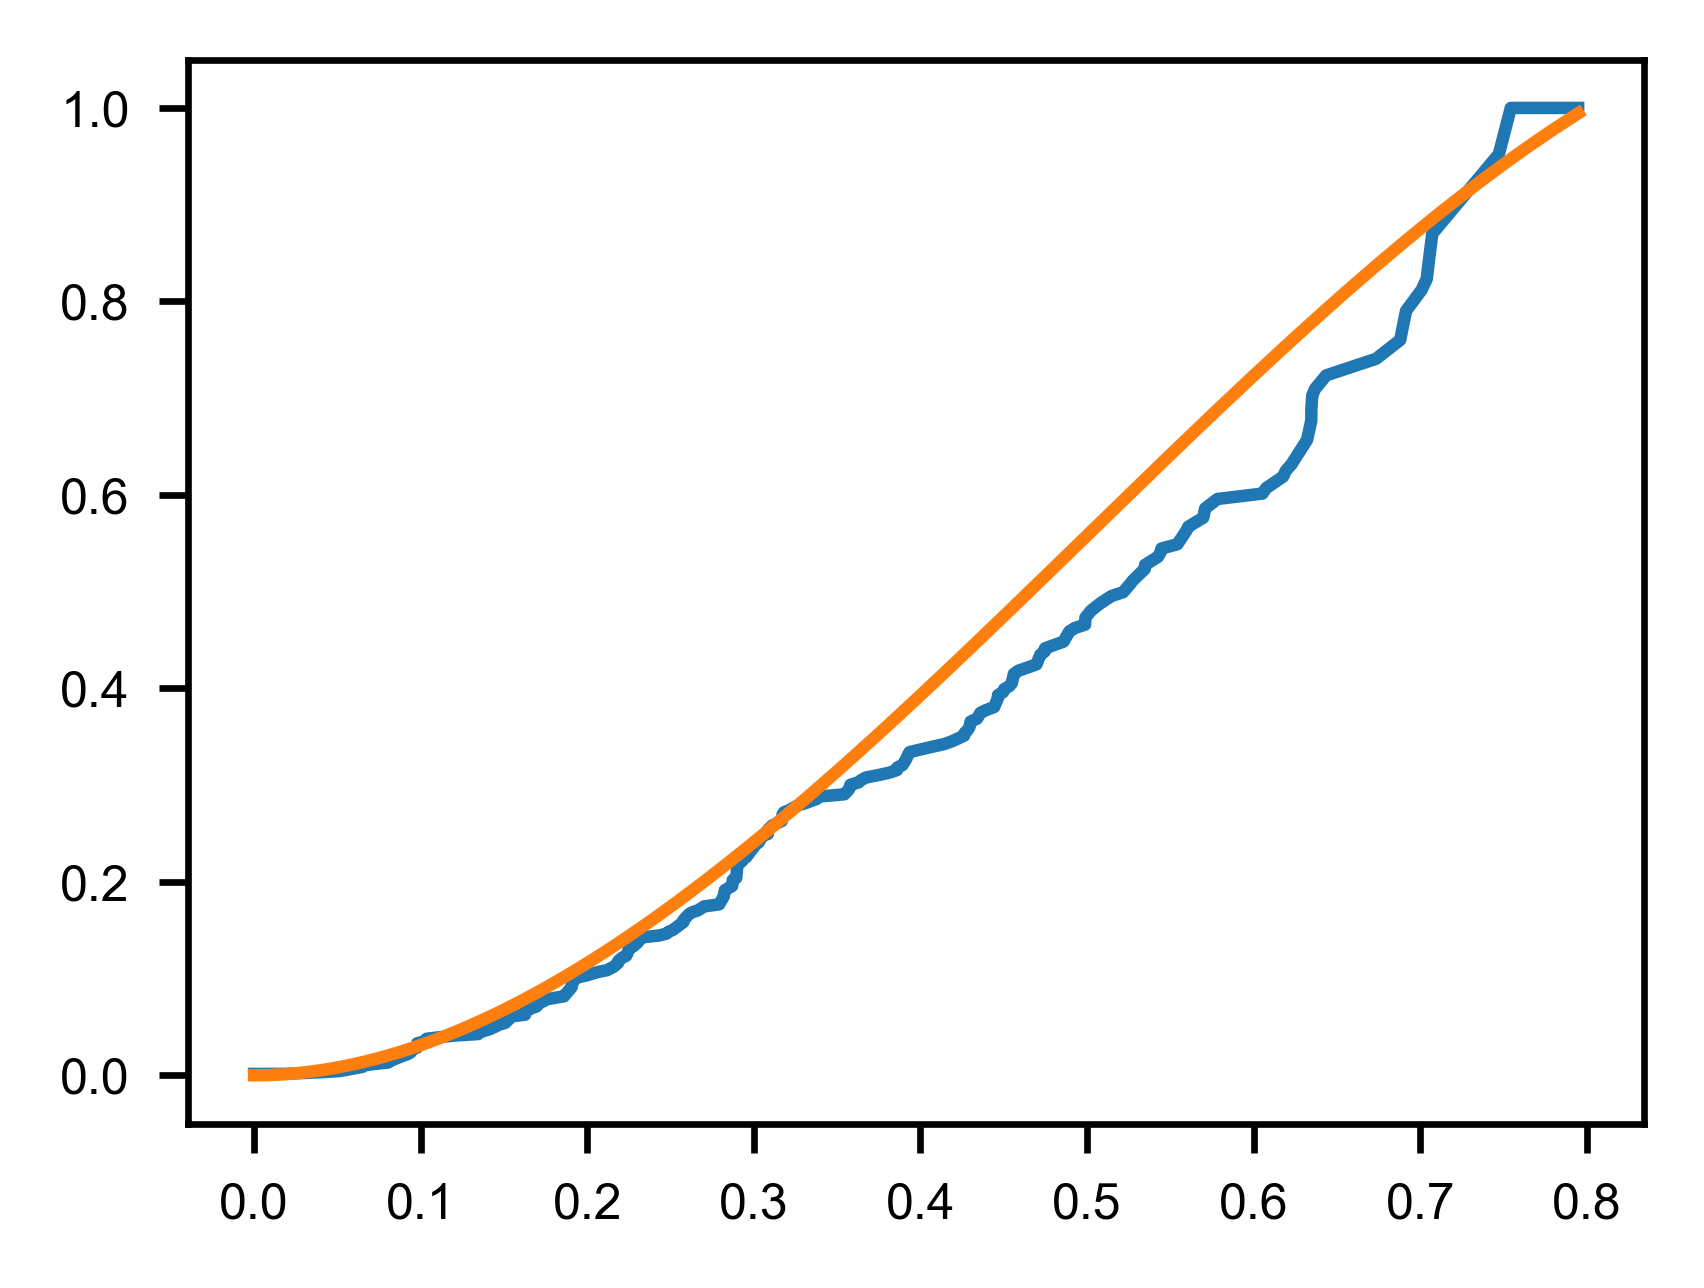

In [103]:
plt.plot(all_times, cdf_int)
plt.plot(all_times, var.cdf(all_times) / var.cdf(T))